In [4]:
%matplotlib inline

import os
from glob import glob
import matplotlib.pyplot as plt
# import estnltk
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from math import sqrt
from gensim.models import Word2Vec
# from numba import jit, autojit
from sklearn.manifold import MDS, TSNE

from sklearn.metrics import homogeneity_score
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, linear_kernel, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

from hdbscan import HDBSCAN
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, DBSCAN 
import pickle
import random
import os
import string
import time
import logging
import seaborn as sns
from sklearn.preprocessing import normalize
import pyamg


from keras.layers import Input, Dense, LSTM, RepeatVector
from keras.models import Model
from keras.datasets import mnist
from keras.models import model_from_json
import numpy as np
# import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from keras_tqdm import TQDMNotebookCallback
import logging
import json


Slow version of gensim.models.doc2vec is being used
Using TensorFlow backend.


In [4]:
log(10)

10


In [5]:
cbow_model = KeyedVectors.load_word2vec_format('autoencoding/lemmas.cbow.s100.w2v.bin', binary=True)

In [6]:
sg_model = KeyedVectors.load_word2vec_format('autoencoding/lemmas.sg.s100.w2v.bin', binary=True)

In [7]:
logger = logging.getLogger('experiments')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('experiments.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

def log(txt):
    print(txt)
    logger.info(txt)
    
def normalize(arr):
    print('normalizing')
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))

def labels_filename(distance_filename, subdir, **kwargs):
    kwarg_list = []
    for k, v in kwargs.items():
        kwarg_list.append("_".join(map(str,(k, v))))
    joined_kwarg_list = "_".join(kwarg_list)
    return os.path.join('datasets/labels',
                        subdir, 
                        distance_filename.replace('datasets/', '')
                                         .replace('/', '_')
                                         .replace('.npy', "_"+joined_kwarg_list+'.npy'))


In [2]:
word2vec_model = Word2Vec.load_word2vec_format('word2vec-models/lemmas.cbow.s100.w2v.bin', binary=True)

In [15]:
sim_files = glob('../datasets/apple-rock-pear/*sim*') + \
        glob('../datasets/apple-rock/*sim*') + \
        glob('../datasets/apple-pear/*sim*') + \
        glob('../datasets/rock-pear/*sim*') + \
        glob('../datasets/sampled/apple-rock-pear/*sim*') + \
        glob('../datasets/sampled/apple-rock/*sim*') + \
        glob('../datasets/sampled/apple-pear/*sim*') + \
        glob('../datasets/sampled/rock-pear/*sim*')

In [17]:
len(sim_files)

128

### extract architectures

In [8]:
archifiles = glob('autoencoding/model-architectures/*_a_*')
archifiles

['autoencoding/model-architectures/sg_3814362_cc4_a_2_t_8_d_[128, 64].json',
 'autoencoding/model-architectures/3782636_cc3_a_1_t_6_d_[128].json',
 'autoencoding/model-architectures/3784201_õk4_a_2_t_8_d_[64, 32].json',
 'autoencoding/model-architectures/sg_3813009_js4_a_2_t_8_d_[128, 64].json',
 'autoencoding/model-architectures/sg_3803874_õk3_a_2_t_6_d_[128, 128].json',
 'autoencoding/model-architectures/sg_3818134_cc4_a_4_t_8_d_[32, 32, 32].json',
 'autoencoding/model-architectures/3791052_õk3_a_4_t_6_d_[128, 64, 32].json',
 'autoencoding/model-architectures/3786761_õk3_a_3_t_6_d_[64, 128].json',
 'autoencoding/model-architectures/3784021_õk4_a_2_t_8_d_[32, 32].json',
 'autoencoding/model-architectures/3781852_õk3_a_1_t_6_d_[32].json',
 'autoencoding/model-architectures/3785940_js3_a_3_t_6_d_[32, 64].json',
 'autoencoding/model-architectures/sg_3800968_õk3_a_1_t_6_d_[16].json',
 'autoencoding/model-architectures/sg_3816837_õk3_a_4_t_6_d_[64, 64, 64].json',
 'autoencoding/model-archi

In [19]:
f1 = 'autoencoding/model-architectures/3791052_õk3_a_4_t_6_d_[128, 64, 32].json'
f2 = 'autoencoding/model-architectures/3786761_õk3_a_3_t_6_d_[64, 128].json'
f3 = 'autoencoding/model-architectures/3784021_õk4_a_2_t_8_d_[32, 32].json'
f4 = 'autoencoding/model-architectures/3781852_õk3_a_1_t_6_d_[32].json'

In [9]:
words = [('joogitee', 'sõidutee'),
        ('õun', 'kivi'),
        ('countries', 'cities')]

datasets_sg = {}
datasets_cbow = {}

for word1, word2 in words:
    print(word1, word2)
    for window in [3,4]:
        for symmetric in [True]:
            print(window, symmetric)
            with open('datasets-bak/contexts/{}_s_{}_w_{}.txt'.format(word1, symmetric, window)) as f:
                contexts1 = f.read().splitlines()
            with open('datasets-bak/contexts/{}_s_{}_w_{}.txt'.format(word2, symmetric, window)) as f:
                contexts2 = f.read().splitlines()
            contexts = contexts1 + contexts2

            X_cbow = np.zeros((len(contexts), window*2, 100))
            X_sg = np.zeros((len(contexts), window*2, 100))
            for i, line in enumerate(contexts):
                X_cbow[i] = cbow_model[line.split()]
                X_sg[i] = sg_model[line.split()]
                
            abbr = word1[0] + word2[0] + str(window)
            print(abbr)
#             x_train, x_test = train_test_split(X, test_size=0.1, random_state=1)

            datasets_sg[abbr] = X_sg
            datasets_cbow[abbr] = X_cbow

joogitee sõidutee
3 True
js3
4 True
js4
õun kivi
3 True
õk3
4 True
õk4
countries cities
3 True
cc3
4 True
cc4


In [10]:
def get_model_from_file(filename):
    with open(filename, 'r') as f:
        json = f.read()

    model = model_from_json(json)

    weights_filename = os.path.basename(filename).replace('.json', '.hdf5')
    model.load_weights('autoencoding/model-weights/{}'.format(weights_filename))
    return model

def get_last_lstm_index(model):
    layer_names = [layer.__class__.__name__ for layer in model.layers]
    return layer_names.index('RepeatVector') - 1


# m1 = get_model_from_file(f1)
# m2 = get_model_from_file(f2)
# m3 = get_model_from_file(f3)
# m4 = get_model_from_file(f4)
def get_encoder_from_file(filename):
    m = get_model_from_file(filename)
    return Model(m.layers[0].input, m.layers[get_last_lstm_index(m)].output)
    
# m = m4
# encoder.layersb


In [17]:
len(archifiles)*3*2 + len(archifiles)*6

3180

In [20]:
len(archifiles)*3

795

In [19]:
len(archifiles)*6

1590

In [25]:
datasets_sg.keys(), datasets_cbow.keys()

(dict_keys(['õk4', 'js3', 'cc3', 'õk3', 'cc4', 'js4']),
 dict_keys(['õk4', 'js3', 'cc3', 'õk3', 'cc4', 'js4']))

In [38]:
os.path.basename(archifiles[0]).replace('.json', ''), 
os.path.basename(labels[0]).replace('_n_2.npy', '').replace('_n_10.npy', '').replace('_n_40.npy', '')

'sg_3814362_cc4_a_2_t_8_d_[128, 64]'

In [47]:
spectral_labels = [os.path.basename(label).replace('_n_2.npy', '').replace('_n_10.npy', '').replace('_n_40.npy', '') for label in labels if 'spectral' in label]

In [48]:
spectral_labels[0]

'sg_3814362_cc4_a_2_t_8_d_[128, 64]'

In [49]:
stripped_archifiles = [os.path.basename(archifile).replace('.json', '') for archifile in archifiles]

In [58]:
real_spectra_files = [os.path.basename(fname) for fname in glob('autoencoder-labels/spectral/*')]


In [62]:
spectral_labels = []

['autoencoder-labels/agglomerative/sg_3814362_cc4_a_2_t_8_d_[128, 64]_n_2.npy',
 'autoencoder-labels/agglomerative/sg_3814362_cc4_a_2_t_8_d_[128, 64]_n_10.npy',
 'autoencoder-labels/agglomerative/sg_3814362_cc4_a_2_t_8_d_[128, 64]_n_40.npy',
 'autoencoder-labels/hdbscan/sg_3814362_cc4_a_2_t_8_d_[128, 64]_size_4_samples_2.npy',
 'autoencoder-labels/hdbscan/sg_3814362_cc4_a_2_t_8_d_[128, 64]_size_4_samples_4.npy',
 'autoencoder-labels/hdbscan/sg_3814362_cc4_a_2_t_8_d_[128, 64]_size_8_samples_2.npy',
 'autoencoder-labels/hdbscan/sg_3814362_cc4_a_2_t_8_d_[128, 64]_size_8_samples_4.npy',
 'autoencoder-labels/hdbscan/sg_3814362_cc4_a_2_t_8_d_[128, 64]_size_2_samples_2.npy',
 'autoencoder-labels/hdbscan/sg_3814362_cc4_a_2_t_8_d_[128, 64]_size_16_samples_8.npy',
 'autoencoder-labels/spectral/sg_3814362_cc4_a_2_t_8_d_[128, 64]_n_2.npy',
 'autoencoder-labels/spectral/sg_3814362_cc4_a_2_t_8_d_[128, 64]_n_10.npy',
 'autoencoder-labels/spectral/sg_3814362_cc4_a_2_t_8_d_[128, 64]_n_40.npy',
 'autoen

In [54]:
i = 0
for stripped_archifile in stripped_archifiles:
    if stripped_archifile not in spectral_labels:
        i+=1
        print(stripped_archifile, i)
        
        
#     print(spectral_label)

In [56]:
spectral_labels, 

['sg_3814362_cc4_a_2_t_8_d_[128, 64]',
 'sg_3814362_cc4_a_2_t_8_d_[128, 64]',
 'sg_3814362_cc4_a_2_t_8_d_[128, 64]',
 '3782636_cc3_a_1_t_6_d_[128]',
 '3782636_cc3_a_1_t_6_d_[128]',
 '3782636_cc3_a_1_t_6_d_[128]',
 '3784201_õk4_a_2_t_8_d_[64, 32]',
 '3784201_õk4_a_2_t_8_d_[64, 32]',
 '3784201_õk4_a_2_t_8_d_[64, 32]',
 'sg_3813009_js4_a_2_t_8_d_[128, 64]',
 'sg_3813009_js4_a_2_t_8_d_[128, 64]',
 'sg_3813009_js4_a_2_t_8_d_[128, 64]',
 'sg_3803874_õk3_a_2_t_6_d_[128, 128]',
 'sg_3803874_õk3_a_2_t_6_d_[128, 128]',
 'sg_3803874_õk3_a_2_t_6_d_[128, 128]',
 'sg_3818134_cc4_a_4_t_8_d_[32, 32, 32]',
 'sg_3818134_cc4_a_4_t_8_d_[32, 32, 32]',
 'sg_3818134_cc4_a_4_t_8_d_[32, 32, 32]',
 '3791052_õk3_a_4_t_6_d_[128, 64, 32]',
 '3791052_õk3_a_4_t_6_d_[128, 64, 32]',
 '3791052_õk3_a_4_t_6_d_[128, 64, 32]',
 '3786761_õk3_a_3_t_6_d_[64, 128]',
 '3786761_õk3_a_3_t_6_d_[64, 128]',
 '3786761_õk3_a_3_t_6_d_[64, 128]',
 '3784021_õk4_a_2_t_8_d_[32, 32]',
 '3784021_õk4_a_2_t_8_d_[32, 32]',
 '3784021_õk4_a_2_t_8

In [70]:
labels = []

missing_archifiles = []
missing_counts = []

for f in tqdm(archifiles):
# def daipohh(f):
    log((f))
    dataset_name_index = f.index('_a_')
    dataset_abbr = f[dataset_name_index-3:dataset_name_index]
    log(dataset_abbr)
    if 'sg' in f:
        log('sg')
        X = datasets_sg[dataset_abbr]
        
    else:
        log('cbow')
        X = datasets_cbow[dataset_abbr]
        

    
#   DAI L2HEB AGGLO

    missing_count = 0
    for n_clusters in [2,10,40]:
        labels_filename = os.path.join('autoencoder-labels/agglomerative/', os.path.basename(f).replace('.json', '_n_{}.npy'.format(n_clusters)))
        labels.append(labels_filename)
        if not os.path.isfile(labels_filename):
            print(labels_filename, 'missing')
            missing_count +=1

#     DAIPOHH HDBSCAN


    
    for min_size, min_samples in params:
        labels_filename = os.path.join('autoencoder-labels/hdbscan/', os.path.basename(f).replace('.json', '_size_{}_samples_{}.npy'.format(min_size, min_samples)))
        labels.append(labels_filename)
        if not os.path.isfile(labels_filename):
            print(labels_filename, 'missing')
            missing_count +=1

    
    
#     SPECTRAL
    for n_clusters in [2,10,40]:
        labels_filename = os.path.join('autoencoder-labels/spectral/', os.path.basename(f).replace('.json', '_n_{}.npy'.format(n_clusters)))
        labels.append(labels_filename)
        if not os.path.isfile(labels_filename):
            print(labels_filename, 'missing')
            missing_count +=1

    if missing_count > 0:
        print(f)
        missing_archifiles.append(f)
    missing_counts.append(missing_count)




 72%|███████▏  | 192/265 [00:00<00:00, 1910.83it/s]

autoencoding/model-architectures/sg_3814362_cc4_a_2_t_8_d_[128, 64].json
cc4
sg
autoencoding/model-architectures/3782636_cc3_a_1_t_6_d_[128].json
cc3
cbow
autoencoding/model-architectures/3784201_õk4_a_2_t_8_d_[64, 32].json
õk4
cbow
autoencoding/model-architectures/sg_3813009_js4_a_2_t_8_d_[128, 64].json
js4
sg
autoencoding/model-architectures/sg_3803874_õk3_a_2_t_6_d_[128, 128].json
õk3
sg
autoencoding/model-architectures/sg_3818134_cc4_a_4_t_8_d_[32, 32, 32].json
cc4
sg
autoencoding/model-architectures/3791052_õk3_a_4_t_6_d_[128, 64, 32].json
õk3
cbow
autoencoding/model-architectures/3786761_õk3_a_3_t_6_d_[64, 128].json
õk3
cbow
autoencoding/model-architectures/3784021_õk4_a_2_t_8_d_[32, 32].json
õk4
cbow
autoencoding/model-architectures/3781852_õk3_a_1_t_6_d_[32].json
õk3
cbow
autoencoding/model-architectures/3785940_js3_a_3_t_6_d_[32, 64].json
js3
cbow
autoencoding/model-architectures/sg_3800968_õk3_a_1_t_6_d_[16].json
õk3
sg
autoencoding/model-architectures/sg_3816837_õk3_a_4_t_6_


100%|██████████| 265/265 [00:00<00:00, 1292.39it/s]

cc4
cbow
autoencoder-labels/agglomerative/3788984_cc4_a_3_t_8_d_[32, 64]_n_2.npy missing
autoencoder-labels/agglomerative/3788984_cc4_a_3_t_8_d_[32, 64]_n_10.npy missing
autoencoder-labels/agglomerative/3788984_cc4_a_3_t_8_d_[32, 64]_n_40.npy missing
autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_4_samples_2.npy missing
autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_4_samples_4.npy missing
autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_8_samples_2.npy missing
autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_8_samples_4.npy missing
autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_2_samples_2.npy missing
autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_16_samples_8.npy missing
autoencoder-labels/spectral/3788984_cc4_a_3_t_8_d_[32, 64]_n_2.npy missing
autoencoder-labels/spectral/3788984_cc4_a_3_t_8_d_[32, 64]_n_10.npy missing
autoencoder-labels/spectral/3788984_cc4_a_3_t_8_d_[32, 64]_n_40.npy missing

In [71]:
missing_archifiles

['autoencoding/model-architectures/sg_3805853_cc3_a_2_t_6_d_[128, 64].json',
 'autoencoding/model-architectures/3783325_js3_a_2_t_6_d_[128, 128].json',
 'autoencoding/model-architectures/3789541_js3_a_4_t_6_d_[64, 64, 64].json',
 'autoencoding/model-architectures/3787283_cc3_a_3_t_6_d_[32, 32].json',
 'autoencoding/model-architectures/3781603_js3_a_1_t_6_d_[32].json',
 'autoencoding/model-architectures/sg_3813251_õk3_a_2_t_6_d_[128, 64].json',
 'autoencoding/model-architectures/sg_3814903_õk4_a_3_t_8_d_[128, 128].json',
 'autoencoding/model-architectures/sg_3816650_js4_a_4_t_8_d_[32, 32, 32].json',
 'autoencoding/model-architectures/sg_3814257_cc4_a_2_t_8_d_[64, 32].json',
 'autoencoding/model-architectures/sg_3802155_cc4_a_1_t_8_d_[16].json',
 'autoencoding/model-architectures/sg_3815493_cc3_a_3_t_6_d_[32, 64].json',
 'autoencoding/model-architectures/sg_3800658_js3_a_1_t_6_d_[128].json',
 'autoencoding/model-architectures/3784704_cc3_a_2_t_6_d_[128, 128].json',
 'autoencoding/model-a

In [67]:
missing_counts

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12

In [27]:
len(labels)

3180

In [73]:
for f in tqdm(missing_archifiles):
# def daipohh(f):
    log((f))
    dataset_name_index = f.index('_a_')
    dataset_abbr = f[dataset_name_index-3:dataset_name_index]
    log(dataset_abbr)
    if 'sg' in f:
        log('sg')
        X = datasets_sg[dataset_abbr]
        
    else:
        log('cbow')
        X = datasets_cbow[dataset_abbr]
    
    try:
        m = get_encoder_from_file(f)
    except Exception as e:
        print(e)
        continue
    features = m.predict(X)

    
#   DAI L2HEB AGGLO

    log((features.shape, 'agglo'))
    eucl = normalize(euclidean_distances(features))
    
    log((np.min(eucl), np.max(eucl), np.mean(eucl)))
    
    for n_clusters in [2,10,40]:
        labels_filename = os.path.join('autoencoder-labels/agglomerative/', os.path.basename(f).replace('.json', '_n_{}.npy'.format(n_clusters)))
        
        if os.path.isfile(labels_filename):
            print(labels_filename, 'is done, continue')
            continue

        model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
        model.fit(eucl)

        log(('saving', labels_filename))
        np.save(labels_filename, model.labels_)
    
    

#     DAIPOHH HDBSCAN


    log((features.shape, 'HDBSCAN'))
    
    for min_size, min_samples in params:
        labels_filename = os.path.join('autoencoder-labels/hdbscan/', os.path.basename(f).replace('.json', '_size_{}_samples_{}.npy'.format(min_size, min_samples)))
        if os.path.isfile(labels_filename):
            print(labels_filename, 'is done, continue')
            continue
        log((min_size, min_samples))
#         model = HDBSCAN(min_cluster_size=min_size, min_samples=min_samples, memory='model-cache/')
        model = HDBSCAN(min_cluster_size=min_size, min_samples=min_samples, memory='model-cache/')
        try:
            model.fit(features)
            log(('saving', labels_filename))
            np.save(labels_filename, model.labels_)
    
        except Exception as e:
            log(e)
    
    
    
    
#     SPECTRAL
    log((features.shape, 'spectral'))
#     eucl = normalize(euclidean_distances(features))
    sim = 1-eucl
    
    log((np.min(sim), np.max(sim), np.mean(sim)))
    
    for n_clusters in [2,10,40]:
        labels_filename = os.path.join('autoencoder-labels/spectral/', os.path.basename(f).replace('.json', '_n_{}.npy'.format(n_clusters)))

        if os.path.isfile(labels_filename):
            print(labels_filename, 'is done, continue')
            continue
        
        model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_jobs=1)
        model.fit(sim)
        log(('saving', labels_filename))
        np.save(labels_filename, model.labels_)






  0%|          | 0/117 [00:00<?, ?it/s]


autoencoding/model-architectures/sg_3805853_cc3_a_2_t_6_d_[128, 64].json
cc3
sg


  1%|          | 1/117 [00:00<00:36,  3.19it/s]

Unable to open file (Unable to open file: name = 'autoencoding/model-weights/sg_3805853_cc3_a_2_t_6_d_[128, 64].hdf5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
autoencoding/model-architectures/3783325_js3_a_2_t_6_d_[128, 128].json
js3
cbow
((960, 128), 'agglo')
normalizing
(0.0, 1.0, 0.41566178)
('saving', 'autoencoder-labels/agglomerative/3783325_js3_a_2_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3783325_js3_a_2_t_6_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3783325_js3_a_2_t_6_d_[128, 128]_n_40.npy')
((960, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3783325_js3_a_2_t_6_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3783325_js3_a_2_t_6_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3783325_js3_a_2_t_6_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3783325_js3_a_2_t_6_d_

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
  2%|▏         | 2/117 [00:06<04:11,  2.19s/it]

('saving', 'autoencoder-labels/spectral/3783325_js3_a_2_t_6_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3789541_js3_a_4_t_6_d_[64, 64, 64].json
js3
cbow
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.42365116)
('saving', 'autoencoder-labels/agglomerative/3789541_js3_a_4_t_6_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3789541_js3_a_4_t_6_d_[64, 64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3789541_js3_a_4_t_6_d_[64, 64, 64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3789541_js3_a_4_t_6_d_[64, 64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3789541_js3_a_4_t_6_d_[64, 64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3789541_js3_a_4_t_6_d_[64, 64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3789541_js3_a_4_t_6_d_[64, 64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3789541_js3_a_4_t_6_d

  3%|▎         | 3/117 [00:13<06:32,  3.45s/it]

('saving', 'autoencoder-labels/spectral/3789541_js3_a_4_t_6_d_[64, 64, 64]_n_40.npy')
autoencoding/model-architectures/3787283_cc3_a_3_t_6_d_[32, 32].json
cc3
cbow
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.53356028)
('saving', 'autoencoder-labels/agglomerative/3787283_cc3_a_3_t_6_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3787283_cc3_a_3_t_6_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3787283_cc3_a_3_t_6_d_[32, 32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3787283_cc3_a_3_t_6_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3787283_cc3_a_3_t_6_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3787283_cc3_a_3_t_6_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3787283_cc3_a_3_t_6_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3787283_cc3_a_3_t_6_d_[32, 32]_size_2_samples_2.n

  3%|▎         | 4/117 [00:39<19:17, 10.24s/it]

('saving', 'autoencoder-labels/spectral/3787283_cc3_a_3_t_6_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/3781603_js3_a_1_t_6_d_[32].json
js3
cbow
((960, 32), 'agglo')
normalizing
(0.0, 1.0, 0.55425853)
('saving', 'autoencoder-labels/agglomerative/3781603_js3_a_1_t_6_d_[32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3781603_js3_a_1_t_6_d_[32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3781603_js3_a_1_t_6_d_[32]_n_40.npy')
((960, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3781603_js3_a_1_t_6_d_[32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3781603_js3_a_1_t_6_d_[32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3781603_js3_a_1_t_6_d_[32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3781603_js3_a_1_t_6_d_[32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3781603_js3_a_1_t_6_d_[32]_size_2_samples_2.npy')
(16, 8)
('saving', 'autoencoder-label

  4%|▍         | 5/117 [00:45<16:51,  9.03s/it]

('saving', 'autoencoder-labels/spectral/3781603_js3_a_1_t_6_d_[32]_n_40.npy')
autoencoding/model-architectures/sg_3813251_õk3_a_2_t_6_d_[128, 64].json
õk3
sg
((2562, 64), 'agglo')
normalizing
(0.0, 1.0, 0.23982491)
('saving', 'autoencoder-labels/agglomerative/sg_3813251_õk3_a_2_t_6_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813251_õk3_a_2_t_6_d_[128, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813251_õk3_a_2_t_6_d_[128, 64]_n_40.npy')
((2562, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813251_õk3_a_2_t_6_d_[128, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813251_õk3_a_2_t_6_d_[128, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813251_õk3_a_2_t_6_d_[128, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813251_õk3_a_2_t_6_d_[128, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813251_õk3_a_2_t_6_d_[1

  5%|▌         | 6/117 [00:55<17:18,  9.36s/it]

('saving', 'autoencoder-labels/spectral/sg_3813251_õk3_a_2_t_6_d_[128, 64]_n_40.npy')
autoencoding/model-architectures/sg_3814903_õk4_a_3_t_8_d_[128, 128].json
õk4
sg
((1884, 128), 'agglo')
normalizing
(0.0, 1.0, 0.33771181)
('saving', 'autoencoder-labels/agglomerative/sg_3814903_õk4_a_3_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814903_õk4_a_3_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814903_õk4_a_3_t_8_d_[128, 128]_n_40.npy')
((1884, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814903_õk4_a_3_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814903_õk4_a_3_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814903_õk4_a_3_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814903_õk4_a_3_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_381490

  6%|▌         | 7/117 [01:04<16:53,  9.22s/it]

('saving', 'autoencoder-labels/spectral/sg_3814903_õk4_a_3_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/sg_3816650_js4_a_4_t_8_d_[32, 32, 32].json
js4
sg
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.30976966)
('saving', 'autoencoder-labels/agglomerative/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbs

  7%|▋         | 8/117 [01:10<15:08,  8.34s/it]

('saving', 'autoencoder-labels/spectral/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3816650_js4_a_4_t_8_d_[32, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3814257_cc4_a_2_t_8_d_[64, 32].json
cc4
sg
((4614, 32), 'agglo')
normalizing
(0.0, 1.0, 0.39959091)
('saving', 'autoencoder-labels/agglomerative/sg_3814257_cc4_a_2_t_8_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814257_cc4_a_2_t_8_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814257_cc4_a_2_t_8_d_[64, 32]_n_40.npy')
((4614, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814257_cc4_a_2_t_8_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814257_cc4_a_2_t_8_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814257_cc4_a_2_t_8_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814257_cc4_a_2_t_8_d_[64, 32]_size

  8%|▊         | 9/117 [01:27<19:35, 10.88s/it]

('saving', 'autoencoder-labels/spectral/sg_3814257_cc4_a_2_t_8_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3802155_cc4_a_1_t_8_d_[16].json
cc4
sg
((4614, 16), 'agglo')
normalizing
(0.0, 1.0, 0.36025852)
('saving', 'autoencoder-labels/agglomerative/sg_3802155_cc4_a_1_t_8_d_[16]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802155_cc4_a_1_t_8_d_[16]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802155_cc4_a_1_t_8_d_[16]_n_40.npy')
((4614, 16), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802155_cc4_a_1_t_8_d_[16]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802155_cc4_a_1_t_8_d_[16]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802155_cc4_a_1_t_8_d_[16]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802155_cc4_a_1_t_8_d_[16]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802155_cc4_a_1_t_8_d_[16]_size_2_samples_2.npy')
(16, 8)

  9%|▊         | 10/117 [01:43<22:03, 12.37s/it]

('saving', 'autoencoder-labels/spectral/sg_3802155_cc4_a_1_t_8_d_[16]_n_40.npy')
autoencoding/model-architectures/sg_3815493_cc3_a_3_t_6_d_[32, 64].json
cc3
sg
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.41221508)
('saving', 'autoencoder-labels/agglomerative/sg_3815493_cc3_a_3_t_6_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3815493_cc3_a_3_t_6_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3815493_cc3_a_3_t_6_d_[32, 64]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3815493_cc3_a_3_t_6_d_[32, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3815493_cc3_a_3_t_6_d_[32, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3815493_cc3_a_3_t_6_d_[32, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3815493_cc3_a_3_t_6_d_[32, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3815493_cc3_a_3_t_6_d_[32, 64

  9%|▉         | 11/117 [02:08<28:36, 16.19s/it]

('saving', 'autoencoder-labels/spectral/sg_3815493_cc3_a_3_t_6_d_[32, 64]_n_40.npy')
autoencoding/model-architectures/sg_3800658_js3_a_1_t_6_d_[128].json
js3
sg
((960, 128), 'agglo')
normalizing
(0.0, 1.0, 0.34340653)
('saving', 'autoencoder-labels/agglomerative/sg_3800658_js3_a_1_t_6_d_[128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800658_js3_a_1_t_6_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800658_js3_a_1_t_6_d_[128]_n_40.npy')
((960, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800658_js3_a_1_t_6_d_[128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800658_js3_a_1_t_6_d_[128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800658_js3_a_1_t_6_d_[128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800658_js3_a_1_t_6_d_[128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800658_js3_a_1_t_6_d_[128]_size_2_samples_2.npy'

 10%|█         | 12/117 [02:15<23:22, 13.36s/it]

('saving', 'autoencoder-labels/spectral/sg_3800658_js3_a_1_t_6_d_[128]_n_40.npy')
autoencoding/model-architectures/3784704_cc3_a_2_t_6_d_[128, 128].json
cc3
cbow
((5980, 128), 'agglo')
normalizing
(0.0, 1.0, 0.51186419)
('saving', 'autoencoder-labels/agglomerative/3784704_cc3_a_2_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3784704_cc3_a_2_t_6_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3784704_cc3_a_2_t_6_d_[128, 128]_n_40.npy')
((5980, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3784704_cc3_a_2_t_6_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3784704_cc3_a_2_t_6_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3784704_cc3_a_2_t_6_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3784704_cc3_a_2_t_6_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3784704_cc3_a_2_t_6_d_[128, 128]_si

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3784704_cc3_a_2_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3784704_cc3_a_2_t_6_d_[128, 128]_n_10.npy')


 11%|█         | 13/117 [02:53<35:57, 20.74s/it]

('saving', 'autoencoder-labels/spectral/3784704_cc3_a_2_t_6_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/sg_3804528_õk4_a_2_t_8_d_[128, 128].json
õk4
sg
((1884, 128), 'agglo')
normalizing
(0.0, 1.0, 0.28005809)
('saving', 'autoencoder-labels/agglomerative/sg_3804528_õk4_a_2_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3804528_õk4_a_2_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3804528_õk4_a_2_t_8_d_[128, 128]_n_40.npy')
((1884, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3804528_õk4_a_2_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3804528_õk4_a_2_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3804528_õk4_a_2_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3804528_õk4_a_2_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3804528_

 12%|█▏        | 14/117 [03:02<29:41, 17.30s/it]

('saving', 'autoencoder-labels/spectral/sg_3804528_õk4_a_2_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/sg_3816599_js3_a_4_t_6_d_[64, 64, 32].json
js3
sg
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.36540744)
('saving', 'autoencoder-labels/agglomerative/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbs

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_n_10.npy')


 13%|█▎        | 15/117 [03:09<24:02, 14.14s/it]

('saving', 'autoencoder-labels/spectral/sg_3816599_js3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3803324_js4_a_2_t_8_d_[128, 128].json
js4
sg
((708, 128), 'agglo')
normalizing
(0.0, 1.0, 0.25413829)
('saving', 'autoencoder-labels/agglomerative/sg_3803324_js4_a_2_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803324_js4_a_2_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803324_js4_a_2_t_8_d_[128, 128]_n_40.npy')
((708, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803324_js4_a_2_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803324_js4_a_2_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803324_js4_a_2_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803324_js4_a_2_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_38033

 14%|█▎        | 16/117 [03:16<20:01, 11.90s/it]

('saving', 'autoencoder-labels/spectral/sg_3803324_js4_a_2_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3803324_js4_a_2_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3793634_cc4_a_4_t_8_d_[32, 32, 32].json
cc4
cbow
((4614, 32), 'agglo')
normalizing
(0.0, 1.0, 0.43527839)
('saving', 'autoencoder-labels/agglomerative/3793634_cc4_a_4_t_8_d_[32, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3793634_cc4_a_4_t_8_d_[32, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3793634_cc4_a_4_t_8_d_[32, 32, 32]_n_40.npy')
((4614, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3793634_cc4_a_4_t_8_d_[32, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3793634_cc4_a_4_t_8_d_[32, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3793634_cc4_a_4_t_8_d_[32, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3793634_cc4_a_4_t_8_d_[32, 32, 32

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3793634_cc4_a_4_t_8_d_[32, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3793634_cc4_a_4_t_8_d_[32, 32, 32]_n_10.npy')


 15%|█▍        | 17/117 [03:33<22:43, 13.63s/it]

('saving', 'autoencoder-labels/spectral/3793634_cc4_a_4_t_8_d_[32, 32, 32]_n_40.npy')
autoencoding/model-architectures/3790092_js4_a_4_t_8_d_[64, 64, 64].json
js4
cbow
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.37565985)
('saving', 'autoencoder-labels/agglomerative/3790092_js4_a_4_t_8_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3790092_js4_a_4_t_8_d_[64, 64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3790092_js4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3790092_js4_a_4_t_8_d_[64, 64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3790092_js4_a_4_t_8_d_[64, 64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3790092_js4_a_4_t_8_d_[64, 64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3790092_js4_a_4_t_8_d_[64, 64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3790092_js4_a_4_t_8

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
 15%|█▌        | 18/117 [03:40<19:03, 11.55s/it]

('saving', 'autoencoder-labels/spectral/3790092_js4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3813868_cc3_a_2_t_6_d_[128, 64].json
cc3
sg
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.43265226)
('saving', 'autoencoder-labels/agglomerative/sg_3813868_cc3_a_2_t_6_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813868_cc3_a_2_t_6_d_[128, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813868_cc3_a_2_t_6_d_[128, 64]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813868_cc3_a_2_t_6_d_[128, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813868_cc3_a_2_t_6_d_[128, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813868_cc3_a_2_t_6_d_[128, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813868_cc3_a_2_t_6_d_[128, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813868_cc3_a_2_

 16%|█▌        | 19/117 [04:08<26:54, 16.48s/it]

('saving', 'autoencoder-labels/spectral/sg_3813868_cc3_a_2_t_6_d_[128, 64]_n_40.npy')
autoencoding/model-architectures/3790243_js4_a_4_t_8_d_[64, 32, 32].json
js4
cbow
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.43504494)
('saving', 'autoencoder-labels/agglomerative/3790243_js4_a_4_t_8_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3790243_js4_a_4_t_8_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3790243_js4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3790243_js4_a_4_t_8_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3790243_js4_a_4_t_8_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3790243_js4_a_4_t_8_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3790243_js4_a_4_t_8_d_[64, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3790243_js4_a_4_t_8

 17%|█▋        | 20/117 [04:15<21:53, 13.54s/it]

('saving', 'autoencoder-labels/spectral/3790243_js4_a_4_t_8_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/3790243_js4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/3791964_cc3_a_4_t_6_d_[32, 32, 32].json
cc3
cbow
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.45232275)
('saving', 'autoencoder-labels/agglomerative/3791964_cc3_a_4_t_6_d_[32, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3791964_cc3_a_4_t_6_d_[32, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3791964_cc3_a_4_t_6_d_[32, 32, 32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3791964_cc3_a_4_t_6_d_[32, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3791964_cc3_a_4_t_6_d_[32, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3791964_cc3_a_4_t_6_d_[32, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3791964_cc3_a_4_t_6_d_[32, 32, 32]_

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3791964_cc3_a_4_t_6_d_[32, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3791964_cc3_a_4_t_6_d_[32, 32, 32]_n_10.npy')


 18%|█▊        | 21/117 [04:41<27:47, 17.37s/it]

('saving', 'autoencoder-labels/spectral/3791964_cc3_a_4_t_6_d_[32, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3801846_cc3_a_1_t_6_d_[32].json
cc3
sg
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.42395198)
('saving', 'autoencoder-labels/agglomerative/sg_3801846_cc3_a_1_t_6_d_[32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801846_cc3_a_1_t_6_d_[32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801846_cc3_a_1_t_6_d_[32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801846_cc3_a_1_t_6_d_[32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801846_cc3_a_1_t_6_d_[32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801846_cc3_a_1_t_6_d_[32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801846_cc3_a_1_t_6_d_[32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801846_cc3_a_1_t_6_d_[32]_size_2_samples_2.npy')
(16, 8

 19%|█▉        | 22/117 [05:07<31:37, 19.97s/it]

('saving', 'autoencoder-labels/spectral/sg_3801846_cc3_a_1_t_6_d_[32]_n_40.npy')
autoencoding/model-architectures/3782166_õk4_a_1_t_8_d_[128].json
õk4
cbow
((1884, 128), 'agglo')
normalizing
(0.0, 1.0, 0.54834396)
('saving', 'autoencoder-labels/agglomerative/3782166_õk4_a_1_t_8_d_[128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3782166_õk4_a_1_t_8_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3782166_õk4_a_1_t_8_d_[128]_n_40.npy')
((1884, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3782166_õk4_a_1_t_8_d_[128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3782166_õk4_a_1_t_8_d_[128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3782166_õk4_a_1_t_8_d_[128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3782166_õk4_a_1_t_8_d_[128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3782166_õk4_a_1_t_8_d_[128]_size_2_samples_2.npy')
(16, 8)
('saving', 'autoe

 20%|█▉        | 23/117 [05:16<26:23, 16.85s/it]

('saving', 'autoencoder-labels/spectral/3782166_õk4_a_1_t_8_d_[128]_n_40.npy')
autoencoding/model-architectures/sg_3801203_õk3_a_1_t_6_d_[128].json
õk3
sg
((2562, 128), 'agglo')
normalizing
(0.0, 1.0, 0.32337198)
('saving', 'autoencoder-labels/agglomerative/sg_3801203_õk3_a_1_t_6_d_[128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801203_õk3_a_1_t_6_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801203_õk3_a_1_t_6_d_[128]_n_40.npy')
((2562, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801203_õk3_a_1_t_6_d_[128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801203_õk3_a_1_t_6_d_[128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801203_õk3_a_1_t_6_d_[128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801203_õk3_a_1_t_6_d_[128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801203_õk3_a_1_t_6_d_[128]_size_2_samples_2.npy')
(1

 21%|██        | 24/117 [05:29<23:56, 15.44s/it]

('saving', 'autoencoder-labels/spectral/sg_3801203_õk3_a_1_t_6_d_[128]_n_40.npy')
autoencoding/model-architectures/3793312_cc3_a_4_t_6_d_[128, 64, 32].json
cc3
cbow
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.52150589)
('saving', 'autoencoder-labels/agglomerative/3793312_cc3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3793312_cc3_a_4_t_6_d_[128, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3793312_cc3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3793312_cc3_a_4_t_6_d_[128, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3793312_cc3_a_4_t_6_d_[128, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3793312_cc3_a_4_t_6_d_[128, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3793312_cc3_a_4_t_6_d_[128, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3793312_cc3_a

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3793312_cc3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3793312_cc3_a_4_t_6_d_[128, 64, 32]_n_10.npy')


 21%|██▏       | 25/117 [06:00<30:53, 20.14s/it]

('saving', 'autoencoder-labels/spectral/3793312_cc3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32].json
cc3
sg
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.26663035)
('saving', 'autoencoder-labels/agglomerative/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-l

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_n_10.npy')


 22%|██▏       | 26/117 [06:28<34:27, 22.72s/it]

('saving', 'autoencoder-labels/spectral/sg_3818055_cc3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3802792_js3_a_2_t_6_d_[64, 64].json
js3
sg
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.35151702)
('saving', 'autoencoder-labels/agglomerative/sg_3802792_js3_a_2_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802792_js3_a_2_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802792_js3_a_2_t_6_d_[64, 64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802792_js3_a_2_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802792_js3_a_2_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802792_js3_a_2_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802792_js3_a_2_t_6_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802792_js3_a_2_t_6_d_

 23%|██▎       | 27/117 [06:36<27:05, 18.06s/it]

('saving', 'autoencoder-labels/spectral/sg_3802792_js3_a_2_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/3786474_õk3_a_3_t_6_d_[128, 128].json
õk3
cbow
((2562, 128), 'agglo')
normalizing
(0.0, 1.0, 0.57219023)
('saving', 'autoencoder-labels/agglomerative/3786474_õk3_a_3_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3786474_õk3_a_3_t_6_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3786474_õk3_a_3_t_6_d_[128, 128]_n_40.npy')
((2562, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3786474_õk3_a_3_t_6_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3786474_õk3_a_3_t_6_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3786474_õk3_a_3_t_6_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3786474_õk3_a_3_t_6_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3786474_õk3_a_3_t_6_d_[128, 128]

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3786474_õk3_a_3_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3786474_õk3_a_3_t_6_d_[128, 128]_n_10.npy')


 24%|██▍       | 28/117 [06:48<24:23, 16.44s/it]

('saving', 'autoencoder-labels/spectral/3786474_õk3_a_3_t_6_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3788872_cc4_a_3_t_8_d_[128, 128].json
cc4
cbow
((4614, 128), 'agglo')
normalizing
(0.0, 1.0, 0.5858919)
('saving', 'autoencoder-labels/agglomerative/3788872_cc4_a_3_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3788872_cc4_a_3_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3788872_cc4_a_3_t_8_d_[128, 128]_n_40.npy')
((4614, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3788872_cc4_a_3_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3788872_cc4_a_3_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3788872_cc4_a_3_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3788872_cc4_a_3_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3788872_cc4_a_3_t_8_d_[128, 128]_s

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3788872_cc4_a_3_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3788872_cc4_a_3_t_8_d_[128, 128]_n_10.npy')


 25%|██▍       | 29/117 [07:15<28:24, 19.37s/it]

('saving', 'autoencoder-labels/spectral/3788872_cc4_a_3_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3786117_js4_a_3_t_8_d_[64, 64].json
js4
cbow
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.50387216)
('saving', 'autoencoder-labels/agglomerative/3786117_js4_a_3_t_8_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3786117_js4_a_3_t_8_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3786117_js4_a_3_t_8_d_[64, 64]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3786117_js4_a_3_t_8_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3786117_js4_a_3_t_8_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3786117_js4_a_3_t_8_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3786117_js4_a_3_t_8_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3786117_js4_a_3_t_8_d_[64, 64]_size_2_samples_2.npy')

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
 26%|██▌       | 30/117 [07:21<22:40, 15.64s/it]

('saving', 'autoencoder-labels/spectral/3786117_js4_a_3_t_8_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/3785816_js3_a_3_t_6_d_[64, 64].json
js3
cbow
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.53409481)
('saving', 'autoencoder-labels/agglomerative/3785816_js3_a_3_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3785816_js3_a_3_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3785816_js3_a_3_t_6_d_[64, 64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3785816_js3_a_3_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3785816_js3_a_3_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3785816_js3_a_3_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3785816_js3_a_3_t_6_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3785816_js3_a_3_t_6_d_[64, 64]_size_2_samples_2.npy')
(

 26%|██▋       | 31/117 [07:29<18:48, 13.12s/it]

('saving', 'autoencoder-labels/spectral/3785816_js3_a_3_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3813970_cc4_a_2_t_8_d_[32, 32].json
cc4
sg
((4614, 32), 'agglo')
normalizing
(0.0, 1.0, 0.36361307)
('saving', 'autoencoder-labels/agglomerative/sg_3813970_cc4_a_2_t_8_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813970_cc4_a_2_t_8_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813970_cc4_a_2_t_8_d_[32, 32]_n_40.npy')
((4614, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813970_cc4_a_2_t_8_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813970_cc4_a_2_t_8_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813970_cc4_a_2_t_8_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813970_cc4_a_2_t_8_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813970_cc4_a_2_t_8_d_[32, 3

 27%|██▋       | 32/117 [07:46<20:22, 14.38s/it]

('saving', 'autoencoder-labels/spectral/sg_3813970_cc4_a_2_t_8_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3816352_cc4_a_3_t_8_d_[64, 128].json
cc4
sg
((4614, 64), 'agglo')
normalizing
(0.0, 1.0, 0.46781054)
('saving', 'autoencoder-labels/agglomerative/sg_3816352_cc4_a_3_t_8_d_[64, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816352_cc4_a_3_t_8_d_[64, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816352_cc4_a_3_t_8_d_[64, 128]_n_40.npy')
((4614, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816352_cc4_a_3_t_8_d_[64, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816352_cc4_a_3_t_8_d_[64, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816352_cc4_a_3_t_8_d_[64, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816352_cc4_a_3_t_8_d_[64, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816352_cc4_a_3_t

 28%|██▊       | 33/117 [08:06<22:35, 16.14s/it]

('saving', 'autoencoder-labels/spectral/sg_3816352_cc4_a_3_t_8_d_[64, 128]_n_40.npy')
autoencoding/model-architectures/sg_3813351_õk4_a_2_t_8_d_[128, 128].json
õk4
sg
((1884, 128), 'agglo')
normalizing
(0.0, 1.0, 0.19081442)
('saving', 'autoencoder-labels/agglomerative/sg_3813351_õk4_a_2_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813351_õk4_a_2_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813351_õk4_a_2_t_8_d_[128, 128]_n_40.npy')
((1884, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813351_õk4_a_2_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813351_õk4_a_2_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813351_õk4_a_2_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813351_õk4_a_2_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_381335

 29%|██▉       | 34/117 [08:16<19:48, 14.32s/it]

('saving', 'autoencoder-labels/spectral/sg_3813351_õk4_a_2_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3784523_cc3_a_2_t_6_d_[64, 64].json
cc3
cbow
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.5062412)
('saving', 'autoencoder-labels/agglomerative/3784523_cc3_a_2_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3784523_cc3_a_2_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3784523_cc3_a_2_t_6_d_[64, 64]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3784523_cc3_a_2_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3784523_cc3_a_2_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3784523_cc3_a_2_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3784523_cc3_a_2_t_6_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3784523_cc3_a_2_t_6_d_[64, 64]_size_2_samples_2.n

 30%|██▉       | 35/117 [08:47<26:17, 19.24s/it]

('saving', 'autoencoder-labels/spectral/3784523_cc3_a_2_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/3783582_js4_a_2_t_8_d_[64, 32].json
js4
cbow
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.38996804)
('saving', 'autoencoder-labels/agglomerative/3783582_js4_a_2_t_8_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3783582_js4_a_2_t_8_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3783582_js4_a_2_t_8_d_[64, 32]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3783582_js4_a_2_t_8_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3783582_js4_a_2_t_8_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3783582_js4_a_2_t_8_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3783582_js4_a_2_t_8_d_[64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3783582_js4_a_2_t_8_d_[64, 32]_size_2_samples_2.npy')
(

 31%|███       | 36/117 [08:54<21:03, 15.60s/it]

('saving', 'autoencoder-labels/spectral/3783582_js4_a_2_t_8_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/3783582_js4_a_2_t_8_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/3788755_cc4_a_3_t_8_d_[64, 64].json
cc4
cbow
((4614, 64), 'agglo')
normalizing
(0.0, 1.0, 0.553958)
('saving', 'autoencoder-labels/agglomerative/3788755_cc4_a_3_t_8_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3788755_cc4_a_3_t_8_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3788755_cc4_a_3_t_8_d_[64, 64]_n_40.npy')
((4614, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3788755_cc4_a_3_t_8_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3788755_cc4_a_3_t_8_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3788755_cc4_a_3_t_8_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3788755_cc4_a_3_t_8_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', '

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3788755_cc4_a_3_t_8_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3788755_cc4_a_3_t_8_d_[64, 64]_n_10.npy')


 32%|███▏      | 37/117 [09:15<22:55, 17.20s/it]

('saving', 'autoencoder-labels/spectral/3788755_cc4_a_3_t_8_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3816289_cc4_a_3_t_8_d_[32, 64].json
cc4
sg
((4614, 32), 'agglo')
normalizing
(0.0, 1.0, 0.41217262)
('saving', 'autoencoder-labels/agglomerative/sg_3816289_cc4_a_3_t_8_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816289_cc4_a_3_t_8_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816289_cc4_a_3_t_8_d_[32, 64]_n_40.npy')
((4614, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816289_cc4_a_3_t_8_d_[32, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816289_cc4_a_3_t_8_d_[32, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816289_cc4_a_3_t_8_d_[32, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816289_cc4_a_3_t_8_d_[32, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816289_cc4_a_3_t_8_d_[32, 6

 32%|███▏      | 38/117 [09:33<22:59, 17.46s/it]

('saving', 'autoencoder-labels/spectral/sg_3816289_cc4_a_3_t_8_d_[32, 64]_n_40.npy')
autoencoding/model-architectures/sg_3800597_js3_a_1_t_6_d_[64].json
js3
sg
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.3600181)
('saving', 'autoencoder-labels/agglomerative/sg_3800597_js3_a_1_t_6_d_[64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800597_js3_a_1_t_6_d_[64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800597_js3_a_1_t_6_d_[64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800597_js3_a_1_t_6_d_[64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800597_js3_a_1_t_6_d_[64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800597_js3_a_1_t_6_d_[64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800597_js3_a_1_t_6_d_[64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800597_js3_a_1_t_6_d_[64]_size_2_samples_2.npy')
(16, 8)
('

 33%|███▎      | 39/117 [09:41<18:45, 14.43s/it]

('saving', 'autoencoder-labels/spectral/sg_3800597_js3_a_1_t_6_d_[64]_n_40.npy')
autoencoding/model-architectures/3786004_js3_a_3_t_6_d_[64, 128].json
js3
cbow
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.50500041)
('saving', 'autoencoder-labels/agglomerative/3786004_js3_a_3_t_6_d_[64, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3786004_js3_a_3_t_6_d_[64, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3786004_js3_a_3_t_6_d_[64, 128]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3786004_js3_a_3_t_6_d_[64, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3786004_js3_a_3_t_6_d_[64, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3786004_js3_a_3_t_6_d_[64, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3786004_js3_a_3_t_6_d_[64, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3786004_js3_a_3_t_6_d_[64, 128]_size_2_samples_2

 34%|███▍      | 40/117 [09:48<15:51, 12.35s/it]

('saving', 'autoencoder-labels/spectral/3786004_js3_a_3_t_6_d_[64, 128]_n_40.npy')
autoencoding/model-architectures/3784795_cc3_a_2_t_6_d_[64, 32].json
cc3
cbow
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.48166776)
('saving', 'autoencoder-labels/agglomerative/3784795_cc3_a_2_t_6_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3784795_cc3_a_2_t_6_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3784795_cc3_a_2_t_6_d_[64, 32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3784795_cc3_a_2_t_6_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3784795_cc3_a_2_t_6_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3784795_cc3_a_2_t_6_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3784795_cc3_a_2_t_6_d_[64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3784795_cc3_a_2_t_6_d_[64, 32]_size_2_samples_2.npy'

 35%|███▌      | 41/117 [10:15<21:15, 16.78s/it]

('saving', 'autoencoder-labels/spectral/3784795_cc3_a_2_t_6_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32].json
cc3
sg
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.40839824)
('saving', 'autoencoder-labels/agglomerative/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_n_10.npy')


 36%|███▌      | 42/117 [10:41<24:17, 19.43s/it]

('saving', 'autoencoder-labels/spectral/sg_3817839_cc3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/3781653_js3_a_1_t_6_d_[128].json
js3
cbow
((960, 128), 'agglo')
normalizing
(0.0, 1.0, 0.53165078)
('saving', 'autoencoder-labels/agglomerative/3781653_js3_a_1_t_6_d_[128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3781653_js3_a_1_t_6_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3781653_js3_a_1_t_6_d_[128]_n_40.npy')
((960, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3781653_js3_a_1_t_6_d_[128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3781653_js3_a_1_t_6_d_[128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3781653_js3_a_1_t_6_d_[128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3781653_js3_a_1_t_6_d_[128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3781653_js3_a_1_t_6_d_[128]_size_2_samples_2.npy')
(16, 8)
('saving', 

 37%|███▋      | 43/117 [10:48<19:38, 15.92s/it]

('saving', 'autoencoder-labels/spectral/3781653_js3_a_1_t_6_d_[128]_n_40.npy')
autoencoding/model-architectures/sg_3814642_js4_a_3_t_8_d_[64, 128].json
js4
sg
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.36371219)
('saving', 'autoencoder-labels/agglomerative/sg_3814642_js4_a_3_t_8_d_[64, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814642_js4_a_3_t_8_d_[64, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814642_js4_a_3_t_8_d_[64, 128]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814642_js4_a_3_t_8_d_[64, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814642_js4_a_3_t_8_d_[64, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814642_js4_a_3_t_8_d_[64, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814642_js4_a_3_t_8_d_[64, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814642_js4_a_3_t_8_d_[64

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3814642_js4_a_3_t_8_d_[64, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3814642_js4_a_3_t_8_d_[64, 128]_n_10.npy')


 38%|███▊      | 44/117 [10:56<16:15, 13.37s/it]

('saving', 'autoencoder-labels/spectral/sg_3814642_js4_a_3_t_8_d_[64, 128]_n_40.npy')
autoencoding/model-architectures/3794270_cc4_a_4_t_8_d_[64, 32, 32].json
cc4
cbow
((4614, 32), 'agglo')
normalizing
(0.0, 1.0, 0.51972848)
('saving', 'autoencoder-labels/agglomerative/3794270_cc4_a_4_t_8_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3794270_cc4_a_4_t_8_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3794270_cc4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
((4614, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3794270_cc4_a_4_t_8_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3794270_cc4_a_4_t_8_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3794270_cc4_a_4_t_8_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3794270_cc4_a_4_t_8_d_[64, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3794270_cc4_a_4_t

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3794270_cc4_a_4_t_8_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3794270_cc4_a_4_t_8_d_[64, 32, 32]_n_10.npy')


 38%|███▊      | 45/117 [11:14<17:51, 14.88s/it]

('saving', 'autoencoder-labels/spectral/3794270_cc4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3814754_õk3_a_3_t_6_d_[32, 64].json
õk3
sg
((2562, 32), 'agglo')
normalizing
(0.0, 1.0, 0.32095772)
('saving', 'autoencoder-labels/agglomerative/sg_3814754_õk3_a_3_t_6_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814754_õk3_a_3_t_6_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814754_õk3_a_3_t_6_d_[32, 64]_n_40.npy')
((2562, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814754_õk3_a_3_t_6_d_[32, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814754_õk3_a_3_t_6_d_[32, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814754_õk3_a_3_t_6_d_[32, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814754_õk3_a_3_t_6_d_[32, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814754_õk3_a_3_t_6_d_[3

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3814754_õk3_a_3_t_6_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3814754_õk3_a_3_t_6_d_[32, 64]_n_10.npy')


 39%|███▉      | 46/117 [11:25<16:01, 13.54s/it]

('saving', 'autoencoder-labels/spectral/sg_3814754_õk3_a_3_t_6_d_[32, 64]_n_40.npy')
autoencoding/model-architectures/3784877_cc3_a_2_t_6_d_[128, 64].json
cc3
cbow
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.50226825)
('saving', 'autoencoder-labels/agglomerative/3784877_cc3_a_2_t_6_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3784877_cc3_a_2_t_6_d_[128, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3784877_cc3_a_2_t_6_d_[128, 64]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3784877_cc3_a_2_t_6_d_[128, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3784877_cc3_a_2_t_6_d_[128, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3784877_cc3_a_2_t_6_d_[128, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3784877_cc3_a_2_t_6_d_[128, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3784877_cc3_a_2_t_6_d_[128, 64]_size_2_sam

 40%|████      | 47/117 [11:55<21:35, 18.51s/it]

('saving', 'autoencoder-labels/spectral/3784877_cc3_a_2_t_6_d_[128, 64]_n_40.npy')
autoencoding/model-architectures/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32].json
õk4
sg
((1884, 32), 'agglo')
normalizing
(0.0, 1.0, 0.21008906)
('saving', 'autoencoder-labels/agglomerative/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_n_40.npy')
((1884, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbsca

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_n_10.npy')


 41%|████      | 48/117 [12:04<18:06, 15.75s/it]

('saving', 'autoencoder-labels/spectral/sg_3817140_õk4_a_4_t_8_d_[32, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32].json
õk4
sg
((1884, 32), 'agglo')
normalizing
(0.0, 1.0, 0.36337748)
('saving', 'autoencoder-labels/agglomerative/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
((1884, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/

 42%|████▏     | 49/117 [12:13<15:32, 13.71s/it]

('saving', 'autoencoder-labels/spectral/sg_3817259_õk4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3801560_õk4_a_1_t_8_d_[128].json
õk4
sg
((1884, 128), 'agglo')
normalizing
(0.0, 1.0, 0.34045652)
('saving', 'autoencoder-labels/agglomerative/sg_3801560_õk4_a_1_t_8_d_[128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801560_õk4_a_1_t_8_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801560_õk4_a_1_t_8_d_[128]_n_40.npy')
((1884, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801560_õk4_a_1_t_8_d_[128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801560_õk4_a_1_t_8_d_[128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801560_õk4_a_1_t_8_d_[128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801560_õk4_a_1_t_8_d_[128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801560_õk4_a_1_t_8_d_[128]_size_2_samples_

 43%|████▎     | 50/117 [12:23<14:06, 12.64s/it]

('saving', 'autoencoder-labels/spectral/sg_3801560_õk4_a_1_t_8_d_[128]_n_40.npy')
autoencoding/model-architectures/sg_3801674_cc3_a_1_t_6_d_[16].json
cc3
sg
((5980, 16), 'agglo')
normalizing
(0.0, 1.0, 0.41766328)
('saving', 'autoencoder-labels/agglomerative/sg_3801674_cc3_a_1_t_6_d_[16]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801674_cc3_a_1_t_6_d_[16]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801674_cc3_a_1_t_6_d_[16]_n_40.npy')
((5980, 16), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801674_cc3_a_1_t_6_d_[16]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801674_cc3_a_1_t_6_d_[16]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801674_cc3_a_1_t_6_d_[16]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801674_cc3_a_1_t_6_d_[16]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801674_cc3_a_1_t_6_d_[16]_size_2_samples_2.npy')
(16, 8)
('

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3801674_cc3_a_1_t_6_d_[16]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3801674_cc3_a_1_t_6_d_[16]_n_10.npy')


 44%|████▎     | 51/117 [12:48<18:03, 16.42s/it]

('saving', 'autoencoder-labels/spectral/sg_3801674_cc3_a_1_t_6_d_[16]_n_40.npy')
autoencoding/model-architectures/sg_3816629_js3_a_4_t_6_d_[128, 64, 32].json
js3
sg
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.33258739)
('saving', 'autoencoder-labels/agglomerative/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hd

 44%|████▍     | 52/117 [12:56<15:03, 13.90s/it]

('saving', 'autoencoder-labels/spectral/sg_3816629_js3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3812997_js4_a_2_t_8_d_[64, 32].json
js4
sg
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.31957752)
('saving', 'autoencoder-labels/agglomerative/sg_3812997_js4_a_2_t_8_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3812997_js4_a_2_t_8_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3812997_js4_a_2_t_8_d_[64, 32]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812997_js4_a_2_t_8_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3812997_js4_a_2_t_8_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812997_js4_a_2_t_8_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3812997_js4_a_2_t_8_d_[64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812997_js4_a_2_t_8_d_

 45%|████▌     | 53/117 [13:04<12:50, 12.04s/it]

('saving', 'autoencoder-labels/spectral/sg_3812997_js4_a_2_t_8_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3812997_js4_a_2_t_8_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/3790593_õk3_a_4_t_6_d_[64, 64, 64].json
õk3
cbow
((2562, 64), 'agglo')
normalizing
(0.0, 1.0, 0.44231245)
('saving', 'autoencoder-labels/agglomerative/3790593_õk3_a_4_t_6_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3790593_õk3_a_4_t_6_d_[64, 64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3790593_õk3_a_4_t_6_d_[64, 64, 64]_n_40.npy')
((2562, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3790593_õk3_a_4_t_6_d_[64, 64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3790593_õk3_a_4_t_6_d_[64, 64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3790593_õk3_a_4_t_6_d_[64, 64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3790593_õk3_a_4_t_6_d_[64, 64, 64]_si

 46%|████▌     | 54/117 [13:15<12:24, 11.82s/it]

('saving', 'autoencoder-labels/spectral/3790593_õk3_a_4_t_6_d_[64, 64, 64]_n_40.npy')
autoencoding/model-architectures/3781631_js3_a_1_t_6_d_[64].json
js3
cbow
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.4972426)
('saving', 'autoencoder-labels/agglomerative/3781631_js3_a_1_t_6_d_[64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3781631_js3_a_1_t_6_d_[64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3781631_js3_a_1_t_6_d_[64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3781631_js3_a_1_t_6_d_[64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3781631_js3_a_1_t_6_d_[64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3781631_js3_a_1_t_6_d_[64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3781631_js3_a_1_t_6_d_[64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3781631_js3_a_1_t_6_d_[64]_size_2_samples_2.npy')
(16, 8)
('saving', 'autoencoder-la

 47%|████▋     | 55/117 [13:23<10:58, 10.63s/it]

('saving', 'autoencoder-labels/spectral/3781631_js3_a_1_t_6_d_[64]_n_40.npy')
autoencoding/model-architectures/3786943_õk4_a_3_t_8_d_[64, 64].json
õk4
cbow
((1884, 64), 'agglo')
normalizing
(0.0, 1.0, 0.47971341)
('saving', 'autoencoder-labels/agglomerative/3786943_õk4_a_3_t_8_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3786943_õk4_a_3_t_8_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3786943_õk4_a_3_t_8_d_[64, 64]_n_40.npy')
((1884, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3786943_õk4_a_3_t_8_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3786943_õk4_a_3_t_8_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3786943_õk4_a_3_t_8_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3786943_õk4_a_3_t_8_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3786943_õk4_a_3_t_8_d_[64, 64]_size_2_samples_2.npy')
(16

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3786943_õk4_a_3_t_8_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3786943_õk4_a_3_t_8_d_[64, 64]_n_10.npy')


 48%|████▊     | 56/117 [13:33<10:32, 10.36s/it]

('saving', 'autoencoder-labels/spectral/3786943_õk4_a_3_t_8_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32].json
õk3
sg
((2562, 64), 'agglo')
normalizing
(0.0, 1.0, 0.31942791)
('saving', 'autoencoder-labels/agglomerative/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
((2562, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_n_10.npy')


 49%|████▊     | 57/117 [13:44<10:38, 10.64s/it]

('saving', 'autoencoder-labels/spectral/sg_3817066_õk3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3816742_js4_a_4_t_8_d_[64, 64, 32].json
js4
sg
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.39127681)
('saving', 'autoencoder-labels/agglomerative/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/h

 50%|████▉     | 58/117 [13:52<09:39,  9.83s/it]

('saving', 'autoencoder-labels/spectral/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3816742_js4_a_4_t_8_d_[64, 64, 32]_n_40.npy')
autoencoding/model-architectures/3785512_cc4_a_2_t_8_d_[128, 64].json
cc4
cbow
((4614, 64), 'agglo')
normalizing
(0.0, 1.0, 0.53259897)
('saving', 'autoencoder-labels/agglomerative/3785512_cc4_a_2_t_8_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3785512_cc4_a_2_t_8_d_[128, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3785512_cc4_a_2_t_8_d_[128, 64]_n_40.npy')
((4614, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3785512_cc4_a_2_t_8_d_[128, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3785512_cc4_a_2_t_8_d_[128, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3785512_cc4_a_2_t_8_d_[128, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3785512_cc4_a_2_t_8_d_[128, 64]_size_8_samples_4.n

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3785512_cc4_a_2_t_8_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3785512_cc4_a_2_t_8_d_[128, 64]_n_10.npy')


 50%|█████     | 59/117 [14:13<12:47, 13.23s/it]

('saving', 'autoencoder-labels/spectral/3785512_cc4_a_2_t_8_d_[128, 64]_n_40.npy')
autoencoding/model-architectures/sg_3813017_õk3_a_2_t_6_d_[32, 32].json
õk3
sg
((2562, 32), 'agglo')
normalizing
(0.0, 1.0, 0.30656207)
('saving', 'autoencoder-labels/agglomerative/sg_3813017_õk3_a_2_t_6_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813017_õk3_a_2_t_6_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813017_õk3_a_2_t_6_d_[32, 32]_n_40.npy')
((2562, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813017_õk3_a_2_t_6_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813017_õk3_a_2_t_6_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813017_õk3_a_2_t_6_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813017_õk3_a_2_t_6_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813017_õk3_a_2_t_6_d_[32, 

 51%|█████▏    | 60/117 [14:24<11:51, 12.48s/it]

('saving', 'autoencoder-labels/spectral/sg_3813017_õk3_a_2_t_6_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3802969_js3_a_2_t_6_d_[64, 32].json
js3
sg
((960, 32), 'agglo')
normalizing
(0.0, 1.0, 0.35902083)
('saving', 'autoencoder-labels/agglomerative/sg_3802969_js3_a_2_t_6_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802969_js3_a_2_t_6_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802969_js3_a_2_t_6_d_[64, 32]_n_40.npy')
((960, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802969_js3_a_2_t_6_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802969_js3_a_2_t_6_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802969_js3_a_2_t_6_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802969_js3_a_2_t_6_d_[64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802969_js3_a_2_t_6_d_[64, 

 52%|█████▏    | 61/117 [14:32<10:25, 11.17s/it]

('saving', 'autoencoder-labels/spectral/sg_3802969_js3_a_2_t_6_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/3787876_cc3_a_3_t_6_d_[128, 128].json
cc3
cbow
((5980, 128), 'agglo')
normalizing
(0.0, 1.0, 0.56405371)
('saving', 'autoencoder-labels/agglomerative/3787876_cc3_a_3_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3787876_cc3_a_3_t_6_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3787876_cc3_a_3_t_6_d_[128, 128]_n_40.npy')
((5980, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3787876_cc3_a_3_t_6_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3787876_cc3_a_3_t_6_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3787876_cc3_a_3_t_6_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3787876_cc3_a_3_t_6_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3787876_cc3_a_3_t_6_d_[128, 128]

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3787876_cc3_a_3_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3787876_cc3_a_3_t_6_d_[128, 128]_n_10.npy')


 53%|█████▎    | 62/117 [15:14<18:36, 20.30s/it]

('saving', 'autoencoder-labels/spectral/3787876_cc3_a_3_t_6_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3789936_js3_a_4_t_6_d_[128, 64, 32].json
js3
cbow
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.34300148)
('saving', 'autoencoder-labels/agglomerative/3789936_js3_a_4_t_6_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3789936_js3_a_4_t_6_d_[128, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3789936_js3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3789936_js3_a_4_t_6_d_[128, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3789936_js3_a_4_t_6_d_[128, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3789936_js3_a_4_t_6_d_[128, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3789936_js3_a_4_t_6_d_[128, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3789936_js3_a

 54%|█████▍    | 63/117 [15:22<15:04, 16.75s/it]

('saving', 'autoencoder-labels/spectral/3789936_js3_a_4_t_6_d_[128, 64, 32]_n_40.npy')
autoencoding/model-architectures/3783286_js3_a_2_t_6_d_[64, 64].json
js3
cbow
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.44492659)
('saving', 'autoencoder-labels/agglomerative/3783286_js3_a_2_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3783286_js3_a_2_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3783286_js3_a_2_t_6_d_[64, 64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3783286_js3_a_2_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3783286_js3_a_2_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3783286_js3_a_2_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3783286_js3_a_2_t_6_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3783286_js3_a_2_t_6_d_[64, 64]_size_2_samples_2.np

 55%|█████▍    | 64/117 [15:31<12:32, 14.21s/it]

('saving', 'autoencoder-labels/spectral/3783286_js3_a_2_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3816697_js4_a_4_t_8_d_[128, 128, 128].json
js4
sg
((708, 128), 'agglo')
normalizing
(0.0, 1.0, 0.40202868)
('saving', 'autoencoder-labels/agglomerative/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_n_40.npy')
((708, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'au

 56%|█████▌    | 65/117 [15:39<10:47, 12.45s/it]

('saving', 'autoencoder-labels/spectral/sg_3816697_js4_a_4_t_8_d_[128, 128, 128]_n_40.npy')
autoencoding/model-architectures/3789252_cc4_a_3_t_8_d_[64, 128].json
cc4
cbow
((4614, 64), 'agglo')
normalizing
(0.0, 1.0, 0.54022968)
('saving', 'autoencoder-labels/agglomerative/3789252_cc4_a_3_t_8_d_[64, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3789252_cc4_a_3_t_8_d_[64, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3789252_cc4_a_3_t_8_d_[64, 128]_n_40.npy')
((4614, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3789252_cc4_a_3_t_8_d_[64, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3789252_cc4_a_3_t_8_d_[64, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3789252_cc4_a_3_t_8_d_[64, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3789252_cc4_a_3_t_8_d_[64, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3789252_cc4_a_3_t_8_d_[64, 128]_siz

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3789252_cc4_a_3_t_8_d_[64, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3789252_cc4_a_3_t_8_d_[64, 128]_n_10.npy')


 56%|█████▋    | 66/117 [16:01<13:01, 15.31s/it]

('saving', 'autoencoder-labels/spectral/3789252_cc4_a_3_t_8_d_[64, 128]_n_40.npy')
autoencoding/model-architectures/sg_3805257_cc3_a_2_t_6_d_[128, 128].json
cc3
sg
((5980, 128), 'agglo')
normalizing
(0.0, 1.0, 0.28555149)
('saving', 'autoencoder-labels/agglomerative/sg_3805257_cc3_a_2_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3805257_cc3_a_2_t_6_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3805257_cc3_a_2_t_6_d_[128, 128]_n_40.npy')
((5980, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3805257_cc3_a_2_t_6_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3805257_cc3_a_2_t_6_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3805257_cc3_a_2_t_6_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3805257_cc3_a_2_t_6_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3805257_c

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3805257_cc3_a_2_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3805257_cc3_a_2_t_6_d_[128, 128]_n_10.npy')


 57%|█████▋    | 67/117 [16:42<19:08, 22.97s/it]

('saving', 'autoencoder-labels/spectral/sg_3805257_cc3_a_2_t_6_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/sg_3814617_js4_a_3_t_8_d_[32, 64].json
js4
sg
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.34558955)
('saving', 'autoencoder-labels/agglomerative/sg_3814617_js4_a_3_t_8_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814617_js4_a_3_t_8_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814617_js4_a_3_t_8_d_[32, 64]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814617_js4_a_3_t_8_d_[32, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814617_js4_a_3_t_8_d_[32, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814617_js4_a_3_t_8_d_[32, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814617_js4_a_3_t_8_d_[32, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814617_js4_a_3_t_8_d_[32

 58%|█████▊    | 68/117 [16:50<15:07, 18.52s/it]

('saving', 'autoencoder-labels/spectral/sg_3814617_js4_a_3_t_8_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3814617_js4_a_3_t_8_d_[32, 64]_n_40.npy')
autoencoding/model-architectures/sg_3813477_cc3_a_2_t_6_d_[64, 64].json
cc3
sg
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.43783802)
('saving', 'autoencoder-labels/agglomerative/sg_3813477_cc3_a_2_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813477_cc3_a_2_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813477_cc3_a_2_t_6_d_[64, 64]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813477_cc3_a_2_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813477_cc3_a_2_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813477_cc3_a_2_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813477_cc3_a_2_t_6_d_[64, 64]_size_8_sampl

 59%|█████▉    | 69/117 [17:20<17:28, 21.84s/it]

('saving', 'autoencoder-labels/spectral/sg_3813477_cc3_a_2_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/3782106_õk4_a_1_t_8_d_[64].json
õk4
cbow
((1884, 64), 'agglo')
normalizing
(0.0, 1.0, 0.55411577)
('saving', 'autoencoder-labels/agglomerative/3782106_õk4_a_1_t_8_d_[64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3782106_õk4_a_1_t_8_d_[64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3782106_õk4_a_1_t_8_d_[64]_n_40.npy')
((1884, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3782106_õk4_a_1_t_8_d_[64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3782106_õk4_a_1_t_8_d_[64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3782106_õk4_a_1_t_8_d_[64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3782106_õk4_a_1_t_8_d_[64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3782106_õk4_a_1_t_8_d_[64]_size_2_samples_2.npy')
(16, 8)
('saving', 'autoencoder-

 60%|█████▉    | 70/117 [17:30<14:21, 18.34s/it]

('saving', 'autoencoder-labels/spectral/3782106_õk4_a_1_t_8_d_[64]_n_40.npy')
autoencoding/model-architectures/sg_3814565_js4_a_3_t_8_d_[32, 32].json
js4
sg
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.37948841)
('saving', 'autoencoder-labels/agglomerative/sg_3814565_js4_a_3_t_8_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814565_js4_a_3_t_8_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814565_js4_a_3_t_8_d_[32, 32]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814565_js4_a_3_t_8_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814565_js4_a_3_t_8_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814565_js4_a_3_t_8_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814565_js4_a_3_t_8_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814565_js4_a_3_t_8_d_[32, 32]_siz

 61%|██████    | 71/117 [17:38<11:43, 15.30s/it]

('saving', 'autoencoder-labels/spectral/sg_3814565_js4_a_3_t_8_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3814565_js4_a_3_t_8_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/3792227_cc3_a_4_t_6_d_[64, 64, 64].json
cc3
cbow
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.47305253)
('saving', 'autoencoder-labels/agglomerative/3792227_cc3_a_4_t_6_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3792227_cc3_a_4_t_6_d_[64, 64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3792227_cc3_a_4_t_6_d_[64, 64, 64]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3792227_cc3_a_4_t_6_d_[64, 64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3792227_cc3_a_4_t_6_d_[64, 64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3792227_cc3_a_4_t_6_d_[64, 64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3792227_cc3_a_4_t_6_d_[64, 64, 64]_si

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3792227_cc3_a_4_t_6_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3792227_cc3_a_4_t_6_d_[64, 64, 64]_n_10.npy')


 62%|██████▏   | 72/117 [18:10<15:11, 20.25s/it]

('saving', 'autoencoder-labels/spectral/3792227_cc3_a_4_t_6_d_[64, 64, 64]_n_40.npy')
autoencoding/model-architectures/3783365_js3_a_2_t_6_d_[64, 32].json
js3
cbow
((960, 32), 'agglo')
normalizing
(0.0, 1.0, 0.42133415)
('saving', 'autoencoder-labels/agglomerative/3783365_js3_a_2_t_6_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3783365_js3_a_2_t_6_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3783365_js3_a_2_t_6_d_[64, 32]_n_40.npy')
((960, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3783365_js3_a_2_t_6_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3783365_js3_a_2_t_6_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3783365_js3_a_2_t_6_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3783365_js3_a_2_t_6_d_[64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3783365_js3_a_2_t_6_d_[64, 32]_size_2_samples_2.npy

 62%|██████▏   | 73/117 [18:18<12:17, 16.76s/it]

('saving', 'autoencoder-labels/spectral/3783365_js3_a_2_t_6_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3816019_cc4_a_3_t_8_d_[64, 64].json
cc4
sg
((4614, 64), 'agglo')
normalizing
(0.0, 1.0, 0.48108524)
('saving', 'autoencoder-labels/agglomerative/sg_3816019_cc4_a_3_t_8_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816019_cc4_a_3_t_8_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816019_cc4_a_3_t_8_d_[64, 64]_n_40.npy')
((4614, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816019_cc4_a_3_t_8_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816019_cc4_a_3_t_8_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816019_cc4_a_3_t_8_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816019_cc4_a_3_t_8_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816019_cc4_a_3_t_8_d_[64, 6

 63%|██████▎   | 74/117 [18:41<13:17, 18.54s/it]

('saving', 'autoencoder-labels/spectral/sg_3816019_cc4_a_3_t_8_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3800790_js4_a_1_t_8_d_[32].json
js4
sg
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.39884764)
('saving', 'autoencoder-labels/agglomerative/sg_3800790_js4_a_1_t_8_d_[32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800790_js4_a_1_t_8_d_[32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800790_js4_a_1_t_8_d_[32]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800790_js4_a_1_t_8_d_[32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800790_js4_a_1_t_8_d_[32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800790_js4_a_1_t_8_d_[32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800790_js4_a_1_t_8_d_[32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800790_js4_a_1_t_8_d_[32]_size_2_samples_2.npy')
(16, 8)
(

 64%|██████▍   | 75/117 [18:49<10:49, 15.46s/it]

('saving', 'autoencoder-labels/spectral/sg_3800790_js4_a_1_t_8_d_[32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3800790_js4_a_1_t_8_d_[32]_n_40.npy')
autoencoding/model-architectures/sg_3816721_js4_a_4_t_8_d_[64, 32, 32].json
js4
sg
((708, 32), 'agglo')
normalizing
(0.0, 1.0, 0.37346351)
('saving', 'autoencoder-labels/agglomerative/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
((708, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816721_js4_a_4_t_8_d_[64

 65%|██████▍   | 76/117 [18:58<09:08, 13.38s/it]

('saving', 'autoencoder-labels/spectral/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3816721_js4_a_4_t_8_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3812900_js3_a_2_t_6_d_[64, 64].json
js3
sg
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.31412965)
('saving', 'autoencoder-labels/agglomerative/sg_3812900_js3_a_2_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3812900_js3_a_2_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3812900_js3_a_2_t_6_d_[64, 64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812900_js3_a_2_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3812900_js3_a_2_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812900_js3_a_2_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3812900_js3_a_2_t_6_d_[64, 64]_size_8

 66%|██████▌   | 77/117 [19:07<08:00, 12.01s/it]

('saving', 'autoencoder-labels/spectral/sg_3812900_js3_a_2_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3814495_js3_a_3_t_6_d_[64, 64].json
js3
sg
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.34235796)
('saving', 'autoencoder-labels/agglomerative/sg_3814495_js3_a_3_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814495_js3_a_3_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814495_js3_a_3_t_6_d_[64, 64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814495_js3_a_3_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814495_js3_a_3_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814495_js3_a_3_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814495_js3_a_3_t_6_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814495_js3_a_3_t_6_d_[64, 

 67%|██████▋   | 78/117 [19:16<07:12, 11.09s/it]

('saving', 'autoencoder-labels/spectral/sg_3814495_js3_a_3_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3813266_õk4_a_2_t_8_d_[32, 32].json
õk4
sg
((1884, 32), 'agglo')
normalizing
(0.0, 1.0, 0.30147636)
('saving', 'autoencoder-labels/agglomerative/sg_3813266_õk4_a_2_t_8_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813266_õk4_a_2_t_8_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813266_õk4_a_2_t_8_d_[32, 32]_n_40.npy')
((1884, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813266_õk4_a_2_t_8_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813266_õk4_a_2_t_8_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813266_õk4_a_2_t_8_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813266_õk4_a_2_t_8_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813266_õk4_a_2_t_8_d_[32

 68%|██████▊   | 79/117 [19:26<06:49, 10.79s/it]

('saving', 'autoencoder-labels/spectral/sg_3813266_õk4_a_2_t_8_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/3786605_õk3_a_3_t_6_d_[32, 64].json
õk3
cbow
((2562, 32), 'agglo')
normalizing
(0.0, 1.0, 0.5116995)
('saving', 'autoencoder-labels/agglomerative/3786605_õk3_a_3_t_6_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3786605_õk3_a_3_t_6_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3786605_õk3_a_3_t_6_d_[32, 64]_n_40.npy')
((2562, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3786605_õk3_a_3_t_6_d_[32, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3786605_õk3_a_3_t_6_d_[32, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3786605_õk3_a_3_t_6_d_[32, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3786605_õk3_a_3_t_6_d_[32, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3786605_õk3_a_3_t_6_d_[32, 64]_size_2_samples_2.npy

 68%|██████▊   | 80/117 [19:37<06:48, 11.05s/it]

('saving', 'autoencoder-labels/spectral/3786605_õk3_a_3_t_6_d_[32, 64]_n_40.npy')
autoencoding/model-architectures/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64].json
õk4
sg
((1884, 64), 'agglo')
normalizing
(0.0, 1.0, 0.28796834)
('saving', 'autoencoder-labels/agglomerative/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
((1884, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan

 69%|██████▉   | 81/117 [19:48<06:34, 10.97s/it]

('saving', 'autoencoder-labels/spectral/sg_3817165_õk4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3814483_js3_a_3_t_6_d_[32, 32].json
js3
sg
((960, 32), 'agglo')
normalizing
(0.0, 1.0, 0.37425789)
('saving', 'autoencoder-labels/agglomerative/sg_3814483_js3_a_3_t_6_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814483_js3_a_3_t_6_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814483_js3_a_3_t_6_d_[32, 32]_n_40.npy')
((960, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814483_js3_a_3_t_6_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814483_js3_a_3_t_6_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814483_js3_a_3_t_6_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814483_js3_a_3_t_6_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814483_js3_a_3_t_6_d_[

 70%|███████   | 82/117 [19:57<06:02, 10.34s/it]

('saving', 'autoencoder-labels/spectral/sg_3814483_js3_a_3_t_6_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3803521_js4_a_2_t_8_d_[128, 64].json
js4
sg
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.2679882)
('saving', 'autoencoder-labels/agglomerative/sg_3803521_js4_a_2_t_8_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803521_js4_a_2_t_8_d_[128, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803521_js4_a_2_t_8_d_[128, 64]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803521_js4_a_2_t_8_d_[128, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803521_js4_a_2_t_8_d_[128, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803521_js4_a_2_t_8_d_[128, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803521_js4_a_2_t_8_d_[128, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803521_js4_a_2_t_8_

 71%|███████   | 83/117 [20:06<05:36,  9.88s/it]

('saving', 'autoencoder-labels/spectral/sg_3803521_js4_a_2_t_8_d_[128, 64]_n_40.npy')
autoencoding/model-architectures/3784953_cc4_a_2_t_8_d_[32, 32].json
cc4
cbow
((4614, 32), 'agglo')
normalizing
(0.0, 1.0, 0.43343791)
('saving', 'autoencoder-labels/agglomerative/3784953_cc4_a_2_t_8_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3784953_cc4_a_2_t_8_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3784953_cc4_a_2_t_8_d_[32, 32]_n_40.npy')
((4614, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3784953_cc4_a_2_t_8_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3784953_cc4_a_2_t_8_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3784953_cc4_a_2_t_8_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3784953_cc4_a_2_t_8_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3784953_cc4_a_2_t_8_d_[32, 32]_size_2_samples_2.n

 72%|███████▏  | 84/117 [20:26<07:06, 12.92s/it]

('saving', 'autoencoder-labels/spectral/3784953_cc4_a_2_t_8_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/3784304_cc3_a_2_t_6_d_[32, 32].json
cc3
cbow
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.4686603)
('saving', 'autoencoder-labels/agglomerative/3784304_cc3_a_2_t_6_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3784304_cc3_a_2_t_6_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3784304_cc3_a_2_t_6_d_[32, 32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3784304_cc3_a_2_t_6_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3784304_cc3_a_2_t_6_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3784304_cc3_a_2_t_6_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3784304_cc3_a_2_t_6_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3784304_cc3_a_2_t_6_d_[32, 32]_size_2_samples_2.npy')


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3784304_cc3_a_2_t_6_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3784304_cc3_a_2_t_6_d_[32, 32]_n_10.npy')


 73%|███████▎  | 85/117 [20:55<09:27, 17.72s/it]

('saving', 'autoencoder-labels/spectral/3784304_cc3_a_2_t_6_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3816160_cc4_a_3_t_8_d_[128, 128].json
cc4
sg
((4614, 128), 'agglo')
normalizing
(0.0, 1.0, 0.430538)
('saving', 'autoencoder-labels/agglomerative/sg_3816160_cc4_a_3_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816160_cc4_a_3_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816160_cc4_a_3_t_8_d_[128, 128]_n_40.npy')
((4614, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816160_cc4_a_3_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816160_cc4_a_3_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816160_cc4_a_3_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816160_cc4_a_3_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816160_cc4_

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3816160_cc4_a_3_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3816160_cc4_a_3_t_8_d_[128, 128]_n_10.npy')


 74%|███████▎  | 86/117 [21:22<10:33, 20.42s/it]

('saving', 'autoencoder-labels/spectral/sg_3816160_cc4_a_3_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/sg_3812989_js4_a_2_t_8_d_[128, 128].json
js4
sg
((708, 128), 'agglo')
normalizing
(0.0, 1.0, 0.23756514)
('saving', 'autoencoder-labels/agglomerative/sg_3812989_js4_a_2_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3812989_js4_a_2_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3812989_js4_a_2_t_8_d_[128, 128]_n_40.npy')
((708, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812989_js4_a_2_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3812989_js4_a_2_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812989_js4_a_2_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3812989_js4_a_2_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3812989

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "
 74%|███████▍  | 87/117 [21:31<08:30, 17.03s/it]

('saving', 'autoencoder-labels/spectral/sg_3812989_js4_a_2_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3812989_js4_a_2_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3792661_cc3_a_4_t_6_d_[64, 32, 32].json
cc3
cbow
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.43834254)
('saving', 'autoencoder-labels/agglomerative/3792661_cc3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3792661_cc3_a_4_t_6_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3792661_cc3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3792661_cc3_a_4_t_6_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3792661_cc3_a_4_t_6_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3792661_cc3_a_4_t_6_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3792661_cc3_a_4_t_6_d_[64, 32, 32

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3792661_cc3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3792661_cc3_a_4_t_6_d_[64, 32, 32]_n_10.npy')


 75%|███████▌  | 88/117 [21:59<09:53, 20.45s/it]

('saving', 'autoencoder-labels/spectral/3792661_cc3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/3782694_cc4_a_1_t_8_d_[16].json
cc4
cbow
((4614, 16), 'agglo')
normalizing
(0.0, 1.0, 0.48288363)
('saving', 'autoencoder-labels/agglomerative/3782694_cc4_a_1_t_8_d_[16]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3782694_cc4_a_1_t_8_d_[16]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3782694_cc4_a_1_t_8_d_[16]_n_40.npy')
((4614, 16), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3782694_cc4_a_1_t_8_d_[16]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3782694_cc4_a_1_t_8_d_[16]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3782694_cc4_a_1_t_8_d_[16]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3782694_cc4_a_1_t_8_d_[16]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3782694_cc4_a_1_t_8_d_[16]_size_2_samples_2.npy')
(16, 8)
('saving', 'autoencoder

 76%|███████▌  | 89/117 [22:19<09:24, 20.16s/it]

('saving', 'autoencoder-labels/spectral/3782694_cc4_a_1_t_8_d_[16]_n_40.npy')
autoencoding/model-architectures/3783740_õk3_a_2_t_6_d_[64, 64].json
õk3
cbow
((2562, 64), 'agglo')
normalizing
(0.0, 1.0, 0.30922821)
('saving', 'autoencoder-labels/agglomerative/3783740_õk3_a_2_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3783740_õk3_a_2_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3783740_õk3_a_2_t_6_d_[64, 64]_n_40.npy')
((2562, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3783740_õk3_a_2_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3783740_õk3_a_2_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3783740_õk3_a_2_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3783740_õk3_a_2_t_6_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3783740_õk3_a_2_t_6_d_[64, 64]_size_2_samples_2.npy')
(16

 77%|███████▋  | 90/117 [22:31<08:05, 17.98s/it]

('saving', 'autoencoder-labels/spectral/3783740_õk3_a_2_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/3791697_õk4_a_4_t_8_d_[64, 64, 32].json
õk4
cbow
((1884, 64), 'agglo')
normalizing
(0.0, 1.0, 0.33122522)
('saving', 'autoencoder-labels/agglomerative/3791697_õk4_a_4_t_8_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3791697_õk4_a_4_t_8_d_[64, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3791697_õk4_a_4_t_8_d_[64, 64, 32]_n_40.npy')
((1884, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3791697_õk4_a_4_t_8_d_[64, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3791697_õk4_a_4_t_8_d_[64, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3791697_õk4_a_4_t_8_d_[64, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3791697_õk4_a_4_t_8_d_[64, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3791697_õk4_a_4_t_8_d

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3791697_õk4_a_4_t_8_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3791697_õk4_a_4_t_8_d_[64, 64, 32]_n_10.npy')


 78%|███████▊  | 91/117 [22:43<06:54, 15.95s/it]

('saving', 'autoencoder-labels/spectral/3791697_õk4_a_4_t_8_d_[64, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3801384_õk4_a_1_t_8_d_[32].json
õk4
sg
((1884, 32), 'agglo')
normalizing
(0.0, 1.0, 0.35353661)
('saving', 'autoencoder-labels/agglomerative/sg_3801384_õk4_a_1_t_8_d_[32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801384_õk4_a_1_t_8_d_[32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3801384_õk4_a_1_t_8_d_[32]_n_40.npy')
((1884, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801384_õk4_a_1_t_8_d_[32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801384_õk4_a_1_t_8_d_[32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801384_õk4_a_1_t_8_d_[32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3801384_õk4_a_1_t_8_d_[32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3801384_õk4_a_1_t_8_d_[32]_size_2_samples_2.npy')
(16, 8

 79%|███████▊  | 92/117 [22:53<05:57, 14.32s/it]

('saving', 'autoencoder-labels/spectral/sg_3801384_õk4_a_1_t_8_d_[32]_n_40.npy')
autoencoding/model-architectures/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32].json
cc3
sg
((5980, 64), 'agglo')
normalizing
(0.0, 1.0, 0.38634869)
('saving', 'autoencoder-labels/agglomerative/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
((5980, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_n_10.npy')


 79%|███████▉  | 93/117 [23:24<07:40, 19.21s/it]

('saving', 'autoencoder-labels/spectral/sg_3817940_cc3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3816671_js4_a_4_t_8_d_[64, 64, 64].json
js4
sg
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.34571078)
('saving', 'autoencoder-labels/agglomerative/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hd

 80%|████████  | 94/117 [23:33<06:13, 16.24s/it]

('saving', 'autoencoder-labels/spectral/sg_3816671_js4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3803989_õk3_a_2_t_6_d_[64, 32].json
õk3
sg
((2562, 32), 'agglo')
normalizing
(0.0, 1.0, 0.33397296)
('saving', 'autoencoder-labels/agglomerative/sg_3803989_õk3_a_2_t_6_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803989_õk3_a_2_t_6_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803989_õk3_a_2_t_6_d_[64, 32]_n_40.npy')
((2562, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803989_õk3_a_2_t_6_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803989_õk3_a_2_t_6_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803989_õk3_a_2_t_6_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803989_õk3_a_2_t_6_d_[64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803989_õk3_a_2_t_6_d

 81%|████████  | 95/117 [23:46<05:31, 15.09s/it]

('saving', 'autoencoder-labels/spectral/sg_3803989_õk3_a_2_t_6_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3813182_õk3_a_2_t_6_d_[128, 128].json
õk3
sg
((2562, 128), 'agglo')
normalizing
(0.0, 1.0, 0.28168949)
('saving', 'autoencoder-labels/agglomerative/sg_3813182_õk3_a_2_t_6_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813182_õk3_a_2_t_6_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3813182_õk3_a_2_t_6_d_[128, 128]_n_40.npy')
((2562, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813182_õk3_a_2_t_6_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813182_õk3_a_2_t_6_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813182_õk3_a_2_t_6_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3813182_õk3_a_2_t_6_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3813182

 82%|████████▏ | 96/117 [24:00<05:10, 14.78s/it]

('saving', 'autoencoder-labels/spectral/sg_3813182_õk3_a_2_t_6_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128].json
cc3
sg
((5980, 128), 'agglo')
normalizing
(0.0, 1.0, 0.34269014)
('saving', 'autoencoder-labels/agglomerative/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_n_40.npy')
((5980, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_size_8_samples_4.npy')
(2, 2)
('savin

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_n_10.npy')


 83%|████████▎ | 97/117 [24:35<07:02, 21.12s/it]

('saving', 'autoencoder-labels/spectral/sg_3817754_cc3_a_4_t_6_d_[128, 128, 128]_n_40.npy')
autoencoding/model-architectures/3790794_õk3_a_4_t_6_d_[64, 32, 32].json
õk3
cbow
((2562, 32), 'agglo')
normalizing
(0.0, 1.0, 0.43575582)
('saving', 'autoencoder-labels/agglomerative/3790794_õk3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3790794_õk3_a_4_t_6_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3790794_õk3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
((2562, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3790794_õk3_a_4_t_6_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3790794_õk3_a_4_t_6_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3790794_õk3_a_4_t_6_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3790794_õk3_a_4_t_6_d_[64, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3790794_õk3

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3790794_õk3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3790794_õk3_a_4_t_6_d_[64, 32, 32]_n_10.npy')


 84%|████████▍ | 98/117 [24:48<05:50, 18.45s/it]

('saving', 'autoencoder-labels/spectral/3790794_õk3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3803054_js3_a_2_t_6_d_[128, 64].json
js3
sg
((960, 64), 'agglo')
normalizing
(0.0, 1.0, 0.29597947)
('saving', 'autoencoder-labels/agglomerative/sg_3803054_js3_a_2_t_6_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803054_js3_a_2_t_6_d_[128, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3803054_js3_a_2_t_6_d_[128, 64]_n_40.npy')
((960, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803054_js3_a_2_t_6_d_[128, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803054_js3_a_2_t_6_d_[128, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803054_js3_a_2_t_6_d_[128, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3803054_js3_a_2_t_6_d_[128, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3803054_js3_a_2_t_

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3803054_js3_a_2_t_6_d_[128, 64]_n_10.npy')


 85%|████████▍ | 99/117 [24:57<04:44, 15.83s/it]

('saving', 'autoencoder-labels/spectral/sg_3803054_js3_a_2_t_6_d_[128, 64]_n_40.npy')
autoencoding/model-architectures/3785747_js3_a_3_t_6_d_[32, 32].json
js3
cbow
((960, 32), 'agglo')
normalizing
(0.0, 1.0, 0.47113901)
('saving', 'autoencoder-labels/agglomerative/3785747_js3_a_3_t_6_d_[32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3785747_js3_a_3_t_6_d_[32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3785747_js3_a_3_t_6_d_[32, 32]_n_40.npy')
((960, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3785747_js3_a_3_t_6_d_[32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3785747_js3_a_3_t_6_d_[32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3785747_js3_a_3_t_6_d_[32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3785747_js3_a_3_t_6_d_[32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3785747_js3_a_3_t_6_d_[32, 32]_size_2_samples_2.npy

 85%|████████▌ | 100/117 [25:07<03:56, 13.89s/it]

('saving', 'autoencoder-labels/spectral/3785747_js3_a_3_t_6_d_[32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3814604_js4_a_3_t_8_d_[128, 128].json
js4
sg
((708, 128), 'agglo')
normalizing
(0.0, 1.0, 0.3299571)
('saving', 'autoencoder-labels/agglomerative/sg_3814604_js4_a_3_t_8_d_[128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814604_js4_a_3_t_8_d_[128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814604_js4_a_3_t_8_d_[128, 128]_n_40.npy')
((708, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814604_js4_a_3_t_8_d_[128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814604_js4_a_3_t_8_d_[128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814604_js4_a_3_t_8_d_[128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814604_js4_a_3_t_8_d_[128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814604_js4_a

 86%|████████▋ | 101/117 [25:16<03:21, 12.60s/it]

('saving', 'autoencoder-labels/spectral/sg_3814604_js4_a_3_t_8_d_[128, 128]_n_40.npy')
autoencoding/model-architectures/3788097_cc3_a_3_t_6_d_[32, 64].json
cc3
cbow
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.53531104)
('saving', 'autoencoder-labels/agglomerative/3788097_cc3_a_3_t_6_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3788097_cc3_a_3_t_6_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3788097_cc3_a_3_t_6_d_[32, 64]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3788097_cc3_a_3_t_6_d_[32, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3788097_cc3_a_3_t_6_d_[32, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3788097_cc3_a_3_t_6_d_[32, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3788097_cc3_a_3_t_6_d_[32, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3788097_cc3_a_3_t_6_d_[32, 64]_size_2_samples_2.

 87%|████████▋ | 102/117 [25:47<04:27, 17.87s/it]

('saving', 'autoencoder-labels/spectral/3788097_cc3_a_3_t_6_d_[32, 64]_n_40.npy')
autoencoding/model-architectures/3783492_js4_a_2_t_8_d_[64, 64].json
js4
cbow
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.44327137)
('saving', 'autoencoder-labels/agglomerative/3783492_js4_a_2_t_8_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3783492_js4_a_2_t_8_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3783492_js4_a_2_t_8_d_[64, 64]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3783492_js4_a_2_t_8_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3783492_js4_a_2_t_8_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3783492_js4_a_2_t_8_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3783492_js4_a_2_t_8_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3783492_js4_a_2_t_8_d_[64, 64]_size_2_samples_2.npy')
(

 88%|████████▊ | 103/117 [25:56<03:34, 15.35s/it]

('saving', 'autoencoder-labels/spectral/3783492_js4_a_2_t_8_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3805497_cc3_a_2_t_6_d_[64, 32].json
cc3
sg
((5980, 32), 'agglo')
normalizing
(0.0, 1.0, 0.28964469)
('saving', 'autoencoder-labels/agglomerative/sg_3805497_cc3_a_2_t_6_d_[64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3805497_cc3_a_2_t_6_d_[64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3805497_cc3_a_2_t_6_d_[64, 32]_n_40.npy')
((5980, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3805497_cc3_a_2_t_6_d_[64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3805497_cc3_a_2_t_6_d_[64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3805497_cc3_a_2_t_6_d_[64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3805497_cc3_a_2_t_6_d_[64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3805497_cc3_a_2_t_6_d_[64, 3

 89%|████████▉ | 104/117 [26:26<04:17, 19.78s/it]

('saving', 'autoencoder-labels/spectral/sg_3805497_cc3_a_2_t_6_d_[64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32].json
õk3
sg
((2562, 64), 'agglo')
normalizing
(0.0, 1.0, 0.21845968)
('saving', 'autoencoder-labels/agglomerative/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
((2562, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbs

 90%|████████▉ | 105/117 [26:39<03:34, 17.85s/it]

('saving', 'autoencoder-labels/spectral/sg_3817034_õk3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3802059_cc3_a_1_t_6_d_[128].json
cc3
sg
((5980, 128), 'agglo')
normalizing
(0.0, 1.0, 0.38789347)
('saving', 'autoencoder-labels/agglomerative/sg_3802059_cc3_a_1_t_6_d_[128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802059_cc3_a_1_t_6_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3802059_cc3_a_1_t_6_d_[128]_n_40.npy')
((5980, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802059_cc3_a_1_t_6_d_[128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802059_cc3_a_1_t_6_d_[128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802059_cc3_a_1_t_6_d_[128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3802059_cc3_a_1_t_6_d_[128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3802059_cc3_a_1_t_6_d_[128]_size_2_samples_

 91%|█████████ | 106/117 [27:21<04:33, 24.88s/it]

('saving', 'autoencoder-labels/spectral/sg_3802059_cc3_a_1_t_6_d_[128]_n_40.npy')
autoencoding/model-architectures/3781743_js4_a_1_t_8_d_[64].json
js4
cbow
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.51846045)
('saving', 'autoencoder-labels/agglomerative/3781743_js4_a_1_t_8_d_[64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3781743_js4_a_1_t_8_d_[64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3781743_js4_a_1_t_8_d_[64]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3781743_js4_a_1_t_8_d_[64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3781743_js4_a_1_t_8_d_[64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3781743_js4_a_1_t_8_d_[64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3781743_js4_a_1_t_8_d_[64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3781743_js4_a_1_t_8_d_[64]_size_2_samples_2.npy')
(16, 8)
('saving', 'autoencoder-label

 91%|█████████▏| 107/117 [27:30<03:22, 20.26s/it]

('saving', 'autoencoder-labels/spectral/3781743_js4_a_1_t_8_d_[64]_n_40.npy')
autoencoding/model-architectures/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32].json
õk3
sg
((2562, 32), 'agglo')
normalizing
(0.0, 1.0, 0.11325146)
('saving', 'autoencoder-labels/agglomerative/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
((2562, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_n_10.npy')


 92%|█████████▏| 108/117 [27:43<02:42, 18.07s/it]

('saving', 'autoencoder-labels/spectral/sg_3816971_õk3_a_4_t_6_d_[64, 32, 32]_n_40.npy')
autoencoding/model-architectures/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32].json
cc4
sg
((4614, 64), 'agglo')
normalizing
(0.0, 1.0, 0.4073498)
('saving', 'autoencoder-labels/agglomerative/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_n_40.npy')
((4614, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_n_10.npy')


 93%|█████████▎| 109/117 [28:05<02:33, 19.23s/it]

('saving', 'autoencoder-labels/spectral/sg_3818493_cc4_a_4_t_8_d_[128, 64, 32]_n_40.npy')
autoencoding/model-architectures/sg_3814717_õk3_a_3_t_6_d_[64, 64].json
õk3
sg
((2562, 64), 'agglo')
normalizing
(0.0, 1.0, 0.34973139)
('saving', 'autoencoder-labels/agglomerative/sg_3814717_õk3_a_3_t_6_d_[64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814717_õk3_a_3_t_6_d_[64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3814717_õk3_a_3_t_6_d_[64, 64]_n_40.npy')
((2562, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814717_õk3_a_3_t_6_d_[64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814717_õk3_a_3_t_6_d_[64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814717_õk3_a_3_t_6_d_[64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3814717_õk3_a_3_t_6_d_[64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3814717_õk3_a_3_t_6_

 94%|█████████▍| 110/117 [28:18<02:02, 17.46s/it]

('saving', 'autoencoder-labels/spectral/sg_3814717_õk3_a_3_t_6_d_[64, 64]_n_40.npy')
autoencoding/model-architectures/3791291_õk4_a_4_t_8_d_[64, 64, 64].json
õk4
cbow
((1884, 64), 'agglo')
normalizing
(0.0, 1.0, 0.43352982)
('saving', 'autoencoder-labels/agglomerative/3791291_õk4_a_4_t_8_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3791291_õk4_a_4_t_8_d_[64, 64, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3791291_õk4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
((1884, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3791291_õk4_a_4_t_8_d_[64, 64, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3791291_õk4_a_4_t_8_d_[64, 64, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3791291_õk4_a_4_t_8_d_[64, 64, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3791291_õk4_a_4_t_8_d_[64, 64, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3791291_õk4_a_4_t_

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3791291_õk4_a_4_t_8_d_[64, 64, 64]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3791291_õk4_a_4_t_8_d_[64, 64, 64]_n_10.npy')


 95%|█████████▍| 111/117 [28:30<01:34, 15.75s/it]

('saving', 'autoencoder-labels/spectral/3791291_õk4_a_4_t_8_d_[64, 64, 64]_n_40.npy')
autoencoding/model-architectures/sg_3800912_js4_a_1_t_8_d_[128].json
js4
sg
((708, 128), 'agglo')
normalizing
(0.0, 1.0, 0.31758147)
('saving', 'autoencoder-labels/agglomerative/sg_3800912_js4_a_1_t_8_d_[128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800912_js4_a_1_t_8_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3800912_js4_a_1_t_8_d_[128]_n_40.npy')
((708, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800912_js4_a_1_t_8_d_[128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800912_js4_a_1_t_8_d_[128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800912_js4_a_1_t_8_d_[128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3800912_js4_a_1_t_8_d_[128]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3800912_js4_a_1_t_8_d_[128]_size_2_samples_2.npy

 96%|█████████▌| 112/117 [28:40<01:09, 14.00s/it]

('saving', 'autoencoder-labels/spectral/sg_3800912_js4_a_1_t_8_d_[128]_n_10.npy')
('saving', 'autoencoder-labels/spectral/sg_3800912_js4_a_1_t_8_d_[128]_n_40.npy')
autoencoding/model-architectures/3783624_js4_a_2_t_8_d_[128, 64].json
js4
cbow
((708, 64), 'agglo')
normalizing
(0.0, 1.0, 0.43727812)
('saving', 'autoencoder-labels/agglomerative/3783624_js4_a_2_t_8_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3783624_js4_a_2_t_8_d_[128, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3783624_js4_a_2_t_8_d_[128, 64]_n_40.npy')
((708, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3783624_js4_a_2_t_8_d_[128, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3783624_js4_a_2_t_8_d_[128, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3783624_js4_a_2_t_8_d_[128, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3783624_js4_a_2_t_8_d_[128, 64]_size_8_samples_4.npy')
(2, 2)
('sa

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3783624_js4_a_2_t_8_d_[128, 64]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3783624_js4_a_2_t_8_d_[128, 64]_n_10.npy')


 97%|█████████▋| 113/117 [28:50<00:51, 12.76s/it]

('saving', 'autoencoder-labels/spectral/3783624_js4_a_2_t_8_d_[128, 64]_n_40.npy')
autoencoding/model-architectures/3790911_õk3_a_4_t_6_d_[64, 64, 32].json
õk3
cbow
((2562, 64), 'agglo')
normalizing
(0.0, 1.0, 0.48258817)
('saving', 'autoencoder-labels/agglomerative/3790911_õk3_a_4_t_6_d_[64, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3790911_õk3_a_4_t_6_d_[64, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3790911_õk3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
((2562, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3790911_õk3_a_4_t_6_d_[64, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3790911_õk3_a_4_t_6_d_[64, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3790911_õk3_a_4_t_6_d_[64, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3790911_õk3_a_4_t_6_d_[64, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3790911_õk3_a_4_t_6_

 97%|█████████▋| 114/117 [29:03<00:38, 12.93s/it]

('saving', 'autoencoder-labels/spectral/3790911_õk3_a_4_t_6_d_[64, 64, 32]_n_40.npy')
autoencoding/model-architectures/3794654_cc4_a_4_t_8_d_[128, 64, 32].json
cc4
cbow
((4614, 64), 'agglo')
normalizing
(0.0, 1.0, 0.46739471)
('saving', 'autoencoder-labels/agglomerative/3794654_cc4_a_4_t_8_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3794654_cc4_a_4_t_8_d_[128, 64, 32]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3794654_cc4_a_4_t_8_d_[128, 64, 32]_n_40.npy')
((4614, 64), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3794654_cc4_a_4_t_8_d_[128, 64, 32]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3794654_cc4_a_4_t_8_d_[128, 64, 32]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3794654_cc4_a_4_t_8_d_[128, 64, 32]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3794654_cc4_a_4_t_8_d_[128, 64, 32]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3794654_c

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


('saving', 'autoencoder-labels/spectral/3794654_cc4_a_4_t_8_d_[128, 64, 32]_n_2.npy')
('saving', 'autoencoder-labels/spectral/3794654_cc4_a_4_t_8_d_[128, 64, 32]_n_10.npy')


 98%|█████████▊| 115/117 [29:26<00:31, 15.97s/it]

('saving', 'autoencoder-labels/spectral/3794654_cc4_a_4_t_8_d_[128, 64, 32]_n_40.npy')
autoencoding/model-architectures/3788984_cc4_a_3_t_8_d_[32, 64].json
cc4
cbow
((4614, 32), 'agglo')
normalizing
(0.0, 1.0, 0.53480309)
('saving', 'autoencoder-labels/agglomerative/3788984_cc4_a_3_t_8_d_[32, 64]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/3788984_cc4_a_3_t_8_d_[32, 64]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/3788984_cc4_a_3_t_8_d_[32, 64]_n_40.npy')
((4614, 32), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_8_samples_4.npy')
(2, 2)
('saving', 'autoencoder-labels/hdbscan/3788984_cc4_a_3_t_8_d_[32, 64]_size_2_samples_2.

 99%|█████████▉| 116/117 [29:48<00:17, 17.71s/it]

('saving', 'autoencoder-labels/spectral/3788984_cc4_a_3_t_8_d_[32, 64]_n_40.npy')
autoencoding/model-architectures/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128].json
cc4
sg
((4614, 128), 'agglo')
normalizing
(0.0, 1.0, 0.35840681)
('saving', 'autoencoder-labels/agglomerative/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_n_2.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_n_10.npy')
('saving', 'autoencoder-labels/agglomerative/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_n_40.npy')
((4614, 128), 'HDBSCAN')
(4, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_size_4_samples_2.npy')
(4, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_size_4_samples_4.npy')
(8, 2)
('saving', 'autoencoder-labels/hdbscan/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_size_8_samples_2.npy')
(8, 4)
('saving', 'autoencoder-labels/hdbscan/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_size_8_samples_4.npy')
(2, 2)
('saving', '

100%|██████████| 117/117 [30:14<00:00, 20.10s/it]

('saving', 'autoencoder-labels/spectral/sg_3818243_cc4_a_4_t_8_d_[128, 128, 128]_n_40.npy')


In [77]:
m = get_encoder_from_file(archifiles[0])

features = m.predict(datasets_sg['cc4'])

In [86]:
features

array([[ 0.27598789,  0.12250511,  0.00526725, ..., -0.05751877,
        -0.28797385, -0.71444064],
       [ 0.22823298,  0.08387219, -0.05310742, ..., -0.01007044,
        -0.29447305, -0.6627748 ],
       [ 0.28324136,  0.16712062,  0.10654076, ...,  0.01665552,
        -0.30522287, -0.61740869],
       ..., 
       [-0.00075963, -0.30766559,  0.29627934, ...,  0.20301977,
        -0.25374997, -0.51857662],
       [-0.29649368, -0.32348615,  0.34267604, ..., -0.1185566 ,
        -0.6671837 , -0.55667686],
       [-0.33463785, -0.40685561,  0.40366521, ..., -0.21033616,
        -0.50726217, -0.576823  ]], dtype=float32)

### Spectral

In [89]:
model = SpectralClustering(n_clusters=10, n_jobs=8)
model.fit(features)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=10, n_init=10, n_jobs=8, n_neighbors=10,
          random_state=None)

In [90]:
model.labels_

array([1, 2, 2, ..., 0, 8, 8], dtype=int32)

In [93]:
spectral_cluster_combinations = []
for n_clusters in [2,10,40]:
    for dist_file in dist_files_lsi_cos:
        spectral_cluster_combinations.append([n_clusters,dist_file])
random.shuffle(spectral_cluster_combinations)
len(spectral_cluster_combinations)

276

In [94]:
# VANA KOOD
# for n_clusters in [2,10,40]:
#     print(n_clusters)
#     for dist_file in dist_files:
# #         if random.random() > 0.7:
# #             continue
#         log(dist_file)
#         labels_file = labels_filename(dist_file, 'spectral', n=n_clusters)
#         if os.path.isfile(labels_file):
#             log('file exists')
#             continue
#         try:
#             dist = normalize(np.load(dist_file))
#             sim = 1 - dist
#             model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_jobs=8)
#             model.fit(sim)
#             np.save(labels_file, model.labels_)
#         except Exception as e:
#             log(('ERROR', e))



# for n_clusters in [2,10,40]:
#     print(n_clusters)
#     for dist_file in dist_files_features:
#         if random.random() > 0.7:
#             continue

for n_clusters, dist_file in spectral_cluster_combinations:
    log(('spectral start', dist_file, n_clusters))
    labels_file = labels_filename(dist_file, 'spectral', n=n_clusters)
    if os.path.isfile(labels_file):
        log('file exists')
        continue
    try:
#         dist = normalize(euclidean_distances(np.load(dist_file)))
#         dist = normalize(np.load(dist_file))
#         sim = 1 - dist
        
        dist = np.load(dist_file)
        dist[dist>1] = 1
        sim = 1-dist
        
        log((np.median(sim), np.mean(sim), np.max(sim), np.min(sim)))
        model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_jobs=8)

#         sim = np.load(dist_file)
#         model = SpectralClustering(n_clusters=n_clusters, n_jobs=8)
        model.fit(sim)
        log(('saving', labels_file))
        np.save(labels_file, model.labels_)
    except Exception as e:
        log(('ERROR', e))


('spectral start', 'datasets/tfidf/lsi-cos-dist/tfidf_features_ämber_pang_w_4_s_True_n_2.npy', 40)
(0.81997205401682405, 0.69765553642428524, 1.0, 0.0)
('saving', 'datasets/labels/spectral/tfidf_lsi-cos-dist_tfidf_features_ämber_pang_w_4_s_True_n_2_n_40.npy')
('spectral start', 'datasets/tfidf/lsi-cos-dist/tfidf_features_ämber_pang_w_3_s_True_n_10.npy', 2)
(0.10442332215344607, 0.20291532473699894, 1.0, 0.0)
('saving', 'datasets/labels/spectral/tfidf_lsi-cos-dist_tfidf_features_ämber_pang_w_3_s_True_n_10_n_2.npy')
('spectral start', 'datasets/tfidf/lsi-cos-dist/tfidf_features_õun_kivi_w_3_s_False_n_2.npy', 40)
(0.84113992905798263, 0.70777175971844497, 1.0, 0.0)


/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


('saving', 'datasets/labels/spectral/tfidf_lsi-cos-dist_tfidf_features_õun_kivi_w_3_s_False_n_2_n_40.npy')
('spectral start', 'datasets/tfidf/lsi-cos-dist/tfidf_features_Eesti_TallinnTartu_w_2_s_False_n_10.npy', 2)
(0.17697175057187586, 0.25183651303825183, 1.0, 0.0)
('saving', 'datasets/labels/spectral/tfidf_lsi-cos-dist_tfidf_features_Eesti_TallinnTartu_w_2_s_False_n_10_n_2.npy')
('spectral start', 'datasets/tfidf/lsi-cos-dist/tfidf_features_õun_puder_w_3_s_True_n_40.npy', 40)
(0.016339389402758586, 0.084126850762035882, 1.0, 0.0)
('saving', 'datasets/labels/spectral/tfidf_lsi-cos-dist_tfidf_features_õun_puder_w_3_s_True_n_40_n_40.npy')
('spectral start', 'datasets/tfidf/lsi-cos-dist/tfidf_features_õun_kivi_w_4_s_True_n_10.npy', 10)
(0.19442468744695751, 0.2634103525906577, 1.0, 0.0)
('saving', 'datasets/labels/spectral/tfidf_lsi-cos-dist_tfidf_features_õun_kivi_w_4_s_True_n_10_n_10.npy')
('spectral start', 'datasets/tfidf/lsi-cos-dist/tfidf_features_hea_halb_w_4_s_False_n_40.npy', 1

KeyboardInterrupt: 

### Agglomerative

In [7]:
dist_files = glob('../datasets/angular-distance/*/*') + glob('../datasets/euclidean-distance/*/*') + glob('../datasets/wmd/*')

In [5]:
dist_files = glob('datasets/tfidf/angular-distance/*') + glob('datasets/tfidf/euclidean-distance/*') + \
             glob('datasets/cbow/mean-vec/angular-distance/*') + glob('datasets/cbow/mean-vec/euclidean-distance/*') +\
             glob('datasets/sg/mean-vec/angular-distance/*') + glob('datasets/sg/mean-vec/euclidean-distance/*') + \
             glob('datasets/cbow/wmd/*') + glob('datasets/sg/wmd/*')

In [31]:
dist_files = glob('datasets/datasets-p12/tfidf/*/*')

In [14]:
dist_files_features =\
        glob('datasets/tfidf/mds/*') + glob('datasets/cbow/mds/*') + glob('datasets/sg/mds/*') +\
        glob('datasets/cbow/pca/*') + glob('datasets/sg/pca/*') +\
        glob('datasets/tfidf/lsi/*')

In [83]:
dist_files_lsi_cos = glob('datasets/tfidf/lsi-cos-dist/*')
len(dist_files_lsi_cos)

92

In [91]:
dist = np.load(dist_files_lsi_cos[0])
dist[dist>1] = 1
sim = 1-dist

(array([ 1514262.,   445940.,   352220.,   297484.,   259988.,   230840.,
          186044.,   131708.,    83928.,    77250.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

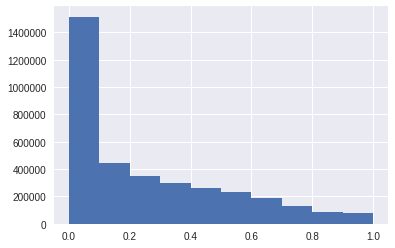

In [92]:
plt.hist(sim.flatten())

In [15]:
len(dist_files_features)

1292

In [33]:
dist_files

['datasets/datasets-p12/tfidf/angular-distance/Eesti_TallinnTartu_w_4_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/õun_kivi_w_3_s_True.npy',
 'datasets/datasets-p12/tfidf/angular-distance/ämber_pang_w_4_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/joogitee_sõidutee_w_4_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/õun_banaan_w_4_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/õun_puder_w_2_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/õun_puder_w_4_s_True.npy',
 'datasets/datasets-p12/tfidf/angular-distance/Eesti_TallinnTartu_w_2_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/õun_banaan_w_3_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/hea_halb_w_2_s_False.npy',
 'datasets/datasets-p12/tfidf/angular-distance/countries_cities_w_2_s_True.npy',
 'datasets/datasets-p12/tfidf/angular-distance/hea_halb_w_4_s_True.npy',
 'datasets/datasets-p12/tfidf/angular-distance/countries_cities_w_2_s_F

In [12]:
len(glob('datasets/cbow/mds/*')), len(glob('datasets/sg/mds/*'))

(500, 360)

In [13]:
dist_files = glob('datasets/cbow/mds/*') + glob('datasets/sg/mds/*')

In [14]:
labels_filename(dist_files[0]

'datasets/cbow/mds/angular-distance_mean-vec_ämber_pang_w_4_s_False_n_10.npy'

'datasets/labels/agglomerative/cbow_mds_angular-distance_mean-vec_ämber_pang_w_4_s_False_n_10_n_12.npy'

<function __main__.labels_filename>

In [66]:

def agglo_cluster(n_clusters, filename):
    log(('agglo start, filename', filename, 'n', n_clusters))
    
    # NB!!! NORMALIZED AND PRECOMPUTED OR NOT
    dist = normalize(np.load(filename))
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    
#     dist = np.load(filename)
#     model = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    
    
    model.fit(dist)
    np.save(labels_filename(filename, 'agglomerative', n_clstrs=n_clusters), model.labels_)
    
agglo_cluster_combinations = []
for n_clusters in [2,10,40]:
    for dist_file in dist_files:
        agglo_cluster_combinations.append([n_clusters,dist_file])
# random.shuffle(agglo_cluster_combinations)
len(agglo_cluster_combinations)

1152

In [22]:
len(dist_files)

860

In [67]:
#algus 00:21
Parallel(n_jobs=8)(delayed(agglo_cluster)(n, filename) for n, filename in agglo_cluster_combinations)

('agglo start, filename', 'datasets/tfidf/angular-distance/Eesti_TallinnTartu_w_4_s_False.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/õun_kivi_w_3_s_True.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/ämber_pang_w_4_s_False.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/joogitee_sõidutee_w_4_s_False.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/õun_banaan_w_4_s_False.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/õun_puder_w_4_s_True.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/Eesti_TallinnTartu_w_2_s_False.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/õun_puder_w_2_s_False.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/õun_banaan_w_3_s_False.npy', 'n', 2)
('agglo start, filename', 'datasets/tfidf/angular-distance/hea_halb_w_2_s_False.npy', 'n', 2)
('agglo start, filename',

KeyboardInterrupt: 

### HDBSCAN

In [11]:
# filename = dist_files[10]
# filename
params = [(x,y) for x in [4,8] for y in [2,4]]
params.append([2,2])
params.append([16,8])
params

[(4, 2), (4, 4), (8, 2), (8, 4), [2, 2], [16, 8]]

In [56]:
dist_files = glob('datasets/tfidf/angular-distance/*') + \
                glob('datasets/tfidf/euclidean-distance/*') + \
                glob('datasets/cbow/mean-vec/angular-distance/*') + \
                glob('datasets/cbow/mean-vec/euclidean-distance/*') + \
                glob('datasets/sg/mean-vec/angular-distance/*') + \
                glob('datasets/sg/mean-vec/euclidean-distance/*') + \
                glob('datasets/cbow/wmd/*') + \
                glob('datasets/sg/wmd/*')

In [59]:
len(dist_files), 48*8

(384, 384)

In [50]:
len(glob('datasets/datasets-p12/tfidf/angular-distance/*')),\
len(glob('datasets/datasets-p12/tfidf/euclidean-distance/*')), \
len(glob('datasets/datasets-p12/cbow/mean-vec/angular-distance/*')),  \
len(glob('datasets/datasets-p12/cbow/mean-vec/euclidean-distance/*')), \
len(glob('datasets/datasets-p12/sg/mean-vec/angular-distance/*')), \
len(glob('datasets/datasets-p12/sg/mean-vec/euclidean-distance/*')), \
len(glob('datasets/datasets-p12/cbow/wmd/*')), \
len(glob('datasets/datasets-p12/sg/wmd/*'))

(48, 48, 48, 48, 48, 48, 48, 48)

In [61]:
labels_filename(dist_files[0], 'hdbscan', n=12)

'datasets/labels/hdbscan/tfidf_angular-distance_Eesti_TallinnTartu_w_4_s_False_n_12.npy'

In [64]:
def hdbscan_cluster(filename):
    print(filename)
    
    # NB WATCH FOR NORMALIZATION AND PRECOMPUTE

#     dist = np.load(filename)
    dist = normalize(np.load(filename))
    
    for min_size, min_samples in params:
#         model = HDBSCAN(min_cluster_size=min_size, min_samples=min_samples, memory='model-cache/')
        model = HDBSCAN(metric='precomputed', n_jobs=1, min_cluster_size=min_size, min_samples=min_samples, memory='model-cache/')
        model.fit(dist)
        
        print("min_size", min_size, "min_samples", min_samples, 'clusters',np.unique(model.labels_).shape)
      
        np.save(labels_filename(filename, 'hdbscan', size=min_size, samples=min_samples), model.labels_)


In [65]:
# alustasin 6:56
Parallel(n_jobs=8)(delayed(hdbscan_cluster)(dist_file) for dist_file in dist_files)

datasets/tfidf/angular-distance/Eesti_TallinnTartu_w_4_s_False.npy
datasets/tfidf/angular-distance/ämber_pang_w_4_s_False.npy
datasets/tfidf/angular-distance/joogitee_sõidutee_w_4_s_False.npy
datasets/tfidf/angular-distance/õun_kivi_w_3_s_True.npy
datasets/tfidf/angular-distance/õun_banaan_w_4_s_False.npy
datasets/tfidf/angular-distance/õun_puder_w_4_s_True.npy
datasets/tfidf/angular-distance/õun_puder_w_2_s_False.npy
datasets/tfidf/angular-distance/Eesti_TallinnTartu_w_2_s_False.npy
min_size 4 min_samples 2 clusters (22,)
min_size 4 min_samples 4 clusters (3,)
min_size 8 min_samples 2 clusters (4,)
min_size 4 min_samples 2 clusters (38,)
min_size 8 min_samples 4 clusters (3,)
min_size 2 min_samples 2 clusters (57,)
min_size 4 min_samples 4 clusters (16,)
min_size 16 min_samples 8 clusters (3,)
datasets/tfidf/angular-distance/õun_banaan_w_3_s_False.npy
min_size 8 min_samples 2 clusters (3,)
min_size 8 min_samples 4 clusters (3,)
min_size 4 min_samples 2 clusters (51,)
min_size 2 min_sa

KeyboardInterrupt: 

In [6]:
results = pickle.load( open("apple-rock-pear-results/agglomerative/n_10_f_cos_dist_w_2_s_False.npy.p", "rb" ) )

In [7]:
results

{'dist_file': '../datasets/apple-rock-pear/cos_dist_w_2_s_False.npy',
 'homogeneity_score': 0.0049978829949085474,
 'n_clusters': 10}

In [ ]:
os.path.split(datafiles[])

In [ ]:
len(results), len(datafiles)

In [236]:
# glob('../dm-project/apple-rock-pear-results/*')
results = pickle.load( open('../dm-project/apple-rock-pear-results/dbscan.p', "rb" ) )
dbscan_results = []
for res in results:
#     if res['homogeneity_score'] > 0.2:
#         print(res)
    dbscan_results.append(res['homogeneity_score'])

In [237]:
results = pickle.load( open('../dm-project/apple-rock-pear-results/spectral_cos_sim.p', "rb" ) )
results
spectral_results = []
for res in results:
    spectral_results.append(res['homogeneity_score'])

In [238]:
agglo_results = []
for file in glob('../dm-project/apple-rock-pear-results/agglomerative/*'):
    res =  pickle.load( open(file, "rb" ) )
    
    agglo_results.append(res['homogeneity_score'])

In [239]:
hdbscan_results = []
hdbscan_files = {}
for file in glob('../dm-project/apple-rock-pear-results/hdbscan/*'):
    res =  pickle.load( open(file, "rb" ) )
    hdbscan_results.append(res['homogeneity_score'])

In [43]:
dectree_results = []
for file in glob('../dm-project/apple-rock-pear-results/dec-tree/*'):
    res =  pickle.load( open(file, "rb" ) )
    
    dectree_results.append(res['homogeneity_score'])

In [45]:
sorted(dectree_results)

[0.0026334809838493315,
 0.0040992245565827567,
 0.0040992245565827567,
 0.0056768073935316628,
 0.0065296713968404424,
 0.0066660164398132426,
 0.0070699808940959796,
 0.0075062870717515278,
 0.0075908307413428159,
 0.0075908307413428159,
 0.0088099446662090238,
 0.0092418575857417268,
 0.010137562436583153,
 0.010137562436583153,
 0.010861015455347383,
 0.011228690669792523,
 0.011228690669792523,
 0.01185369532100178,
 0.011855555258088051,
 0.011947026352216596,
 0.011999759488544086,
 0.012868929529546266,
 0.012868929529546266,
 0.015181932110283678,
 0.015309218568713645,
 0.016315901711999425,
 0.016966853640089347,
 0.01709529886074081,
 0.01709529886074081,
 0.017264248419269594,
 0.017599943398655261,
 0.018660242216530433,
 0.018660242216530433,
 0.02109018974178346,
 0.021101622676032012,
 0.021101622676032012,
 0.021227996711255814,
 0.021227996711255814,
 0.021739188913784364,
 0.022041385727520953,
 0.022041385727520953,
 0.023153354589654701,
 0.023153354589654701,
 0.

In [137]:
len(set(hdbscan_files))

129

In [154]:
hdbscan_original = {'arp':[], 'ar': [], 'ap': [], 'rp': []}
hdbscan_sampled = {'arp':[], 'ar': [], 'ap': [], 'rp': []}

for file in glob('../dm-project/apple-rock-pear-results/hdbscan/*'):
    res =  pickle.load( open(file, "rb" ) )
#     print(file.split('_'))
    abbr = file.split('_')[1]
    sampled = file.split('_')[3]
    if sampled == 'True':
        hdbscan_sampled[abbr].append(res['homogeneity_score'])
    else:
        hdbscan_original[abbr].append(res['homogeneity_score'])

In [188]:
dbscan_original = {'arp':[], 'ar': [], 'ap': [], 'rp': []}
dbscan_sampled = {'arp':[], 'ar': [], 'ap': [], 'rp': []}   
results = pickle.load( open('../dm-project/apple-rock-pear-results/dbscan.p', "rb" ) )
dbscan_results = []
for res in results:
    print(res, )
    abbr = file_abbr(res['dist_file'])
    sampled = 'sampled' in res['dist_file']
    if sampled:
        dbscan_sampled[abbr].append(res['homogeneity_score'])
    else:
        dbscan_original[abbr].append(res['homogeneity_score'])
#     dbscan_results.append(res['homogeneity_score'])

{'dist_file': '../datasets/apple-rock-pear/alignement_dist_w_3_s_True.npy', 'homogeneity_score': 0.00012780147377747995}
{'dist_file': '../datasets/apple-rock-pear/tfidf_cosine_distances_w_3_s_True.npy', 'homogeneity_score': 0.063265801206366865}
{'dist_file': '../datasets/apple-rock-pear/cos_dist_w_3_s_False.npy', 'homogeneity_score': 3.9526795940942855e-05}
{'dist_file': '../datasets/apple-rock-pear/tfidf_cosine_distances_w_2_s_False.npy', 'homogeneity_score': 0.039504995534089982}
{'dist_file': '../datasets/apple-rock-pear/tfidf_cosine_distances_w_4_s_False.npy', 'homogeneity_score': 0.070814907792224768}
{'dist_file': '../datasets/apple-rock-pear/cos_dist_w_2_s_False.npy', 'homogeneity_score': 4.99091986148383e-05}
{'dist_file': '../datasets/apple-rock-pear/alignement_dist_w_2_s_False.npy', 'homogeneity_score': 4.1640137526940276e-05}
{'dist_file': '../datasets/apple-rock-pear/cos_dist_w_4_s_False.npy', 'homogeneity_score': 0.00022831541934018008}
{'dist_file': '../datasets/apple-r

In [187]:
sorted(dbscan_sampled['arp'])

[]

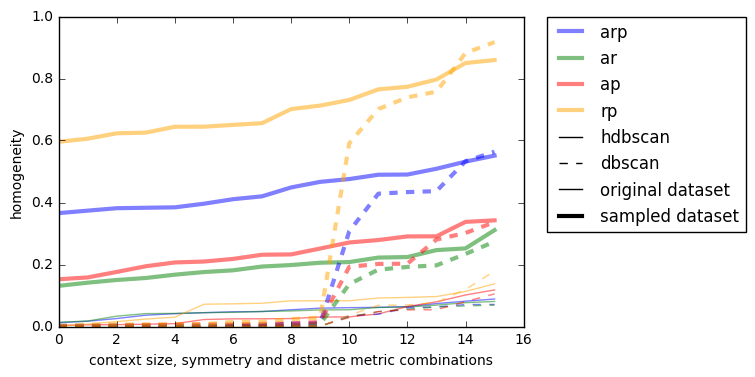

In [212]:
x = np.arange(len(hdbscan_sampled['ar']))
plt.plot(x, sorted(hdbscan_sampled['arp']), label='arp', linewidth=3, c='blue', alpha=0.5)
plt.plot(x, sorted(hdbscan_sampled['ar']), label='ar', linewidth=3, c='green', alpha=0.5)
plt.plot(x, sorted(hdbscan_sampled['ap']), label='ap', linewidth=3, c='red', alpha=0.5)
plt.plot(x, sorted(hdbscan_sampled['rp']), label='rp', linewidth=3, c='orange', alpha=0.5)

plt.plot(x, sorted(hdbscan_original['arp']), linewidth=1, c='blue', alpha=0.5)
plt.plot(x, sorted(hdbscan_original['ar']), linewidth=1, c='green', alpha=0.5)
plt.plot(x, sorted(hdbscan_original['ap']), linewidth=1, c='red', alpha=0.5)
plt.plot(x, sorted(hdbscan_original['rp']), linewidth=1, c='orange', alpha=0.5)


plt.plot(x, sorted(dbscan_sampled['arp']), linewidth=3, c='blue', linestyle='--', alpha=0.5)
plt.plot(x, sorted(dbscan_sampled['ar']), linewidth=3, c='green', linestyle='--', alpha=0.5)
plt.plot(x, sorted(dbscan_sampled['ap']), linewidth=3, c='red', linestyle='--', alpha=0.5)
plt.plot(x, sorted(dbscan_sampled['rp']), linewidth=3, c='orange', linestyle='--', alpha=0.5)

plt.plot(x, sorted(dbscan_original['arp']), linewidth=1, c='blue', linestyle='--', alpha=0.5)
plt.plot(x, sorted(dbscan_original['ar']), linewidth=1, c='green', linestyle='--', alpha=0.5)
plt.plot(x, sorted(dbscan_original['ap']), linewidth=1, c='red', linestyle='--', alpha=0.5)
plt.plot(x, sorted(dbscan_original['rp']), linewidth=1, c='orange', linestyle='--', alpha=0.5)

plt.plot(0,0, label='hdbscan', c='black', linewidth=1)
plt.plot(0,0, label='dbscan', c='black', linewidth=1, linestyle='--')
plt.plot(0,0, label='original dataset', c='black', linewidth=1)
plt.plot(0,0, label='sampled dataset', c='black', linewidth=3)


plt.ylabel('homogeneity')
plt.xlabel('context size, symmetry and distance metric combinations')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

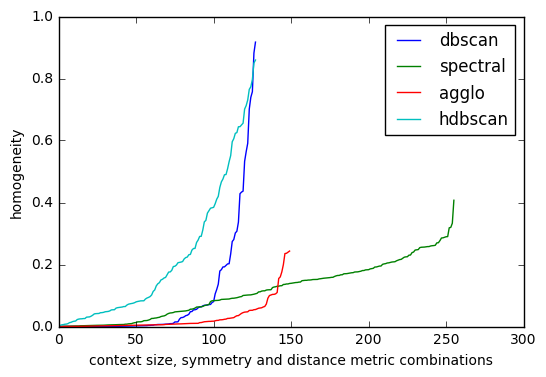

In [248]:
plt.plot(np.arange(len(dbscan_aggregated)), sorted(dbscan_aggregated), label='dbscan')
plt.plot(np.arange(len(spectral_results)), sorted(spectral_results), label='spectral')
plt.plot(np.arange(len(agglo_results)), sorted(agglo_results), label='agglo')
plt.plot(np.arange(len(hdbscan_aggregated)), sorted(hdbscan_aggregated), label='hdbscan')

plt.legend(loc=1)
plt.ylabel('homogeneity')
plt.xlabel('context size, symmetry and distance metric combinations')

In [49]:
len(dist_files), len(hdbscan_results), len(dbscan_results)

NameError: name 'dist_files' is not defined

In [246]:
dbscan_aggregated = []

for key, val in dbscan_sampled.items():
    dbscan_aggregated.extend(val)

for key, val in dbscan_original.items():
    dbscan_aggregated.extend(val)

In [247]:
len(dbscan_aggregated)

128

### knn

In [54]:
dist_file = glob('../datasets/apple-rock/alignement_dist_w_2_s_False.npy')[0]

'../datasets/apple-rock/alignement_dist_w_2_s_False.npy'

In [93]:
dist = np.load(dist_file)
labels = get_true_labels(dist_file)
labels0 = np.where(labels==0)[0]
labels1 = np.where(labels==1)[0]
labels1 = np.random.choice(labels1, size=len(labels0), replace=False)
labels = np.hstack((labels0, labels1))
dist = dist[labels][:,labels]

ar


In [97]:
r = 0.1
k = 3

In [110]:
dist_masked = np.array(dist)
np.fill_diagonal(dist_masked, 1)
small_distances = np.where(dist_masked<r)
small_distances

(array([   1,    1,    6, ..., 5566, 5566, 5566]),
 array([ 702,  844,  382, ..., 3384, 5162, 5564]))

In [111]:
for i in labels0:
    print(np.where(small_distances==i))

(array([], dtype=int64), array([], dtype=int64))
(array([0, 0, 1, 1]), array([   0,    1, 1261, 1507]))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([0, 1]), array([  2, 737]))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]), array([   3,    4,    5,    6,    7,    8,    9,   10,  600,  947, 1769,
       2215, 2382, 3054, 3856, 4360]))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([0, 1]), array([  11, 1586]))
(array([0, 0, 1, 1]), array([  12,   13, 1257, 4311]))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], 

In [6]:
def file_abbr(filename):
    if 'sampled' in filename:
        abbr = "".join([w[0] for w in filename.split('/')[3].split('-')])
    else:
        abbr = "".join([w[0] for w in filename.split('/')[2].split('-')])
    return abbr

def parse_w_s(filename):
    w_index = filename.index('w_')
    window = filename[w_index+2]
    symmetric = filename[w_index+6] == 'T'
    return window, symmetric

def get_true_labels(arr_filename):
#     w_index = arr_filename.index('w_')
#     window = arr_filename[w_index+2]
#     symmetric = arr_filename[w_index+6] == 'T'
    window, symmetric = parse_w_s(arr_filename)
    if 'sampled' in arr_filename:
        abbr = "".join([w[0] for w in arr_filename.split('/')[3].split('-')])
        labels_filename = '../datasets/sampled/labels/{}_w_{}_s_{}.npy'.format(abbr, window, symmetric)
    else:
        abbr = "".join([w[0] for w in arr_filename.split('/')[2].split('-')])
        labels_filename = '../datasets/labels/{}_w_{}_s_{}.npy'.format(abbr, window, symmetric)
    print(abbr)

    labels = np.load(labels_filename)
    return labels

